In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Import the mdates module
from datetime import datetime, timedelta

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Price_Up'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model using data from the 90 days near the specified date
nearby_data = goldDF[(goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')) &
                     (goldDF['Date'] <= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=90)).strftime('%Y-%m-%d'))]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer="adam", loss="mean_squared_error")

# Training the LSTM model with early stopping
callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_lstm.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

# Predictions on the test set
pred_lstm = model_lstm.predict(test_X)
preds_lstm = scaler.inverse_transform(pred_lstm)

# Prepare data for prediction on the specified future date
input_data = goldDF[goldDF['Date'] <= future_date_to_predict][features]
input_data_scaled = scaler.transform(np.array(input_data['Close']).reshape(-1, 1))
X_input = np.array([input_data_scaled[-MOVING_WIN_SIZE:]])

# Predict the gold price for the specified future date using the LSTM model
predicted_price_scaled = model_lstm.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Calculate the date 60 days before and after the specified date
date_after = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=60)).strftime('%Y-%m-%d')

# Extract prices for the specified date and 60 days after if data is available
prices_after = goldDF[goldDF['Date'] == date_after]['Close'].values[0] if not goldDF[goldDF['Date'] == date_after].empty else None
original_price = goldDF[goldDF['Date'] == future_date_to_predict]['Close'].values[0]

# Display the predicted and original prices
print(f"\nThe predicted gold price on {future_date_to_predict} is: ${predicted_price[0, 0]:.2f}")
print(f"The original gold price on {future_date_to_predict} is: ${original_price:.2f}")

# Visualize the LSTM model predictions for 60 days after the specified date
plt.figure(figsize=(12, 8))

# Plotting gold price and predicted prices
index_datetime = pd.to_datetime(goldDF['Date'])  # Convert 'Date' column to datetime
plt.plot(index_datetime[-len(preds_lstm):], goldDF['Close'].values[-len(preds_lstm):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_lstm):], preds_lstm, linewidth=1, label='Predicted Price (LSTM)')

# Display marker for 60 days after the specified date if data is available
if prices_after is not None:
    plt.scatter([datetime.strptime(date_after, '%Y-%m-%d')], [prices_after], color='orange', marker='o', label='60 Days After')

# Set the x-axis tick locator and formatter for better date representation
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))  # Use '%y' for two-digit year representation

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Display other details like title, labels, and legend
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2023-12-10
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.3526 - val_loss: 0.3816
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.2149 - val_loss: 0.2154
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 0.1045 - val_loss: 0.0853
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0302 - val_loss: 0.0109
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0094 - val_loss: 0.0080
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0471 - val_loss: 0.0204
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0723 - val_loss: 0.0129
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0590 - val_loss: 0.0029
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0334 - val_loss:

IndexError: index 0 is out of bounds for axis 0 with size 0

[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2022-10-10
Epoch 1/100
2/2 [==============================] - 2s 390ms/step - loss: 0.1463 - val_loss: 0.3415
Epoch 2/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0950 - val_loss: 0.1821
Epoch 3/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0581 - val_loss: 0.0555
Epoch 4/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0388 - val_loss: 0.0063
Epoch 5/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0448 - val_loss: 0.0052
Epoch 6/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0397 - val_loss: 0.0160
Epoch 7/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0320 - val_loss: 0.0362
Epoch 8/100
2/2 [==============================] - 0s 33ms/step - loss: 0.0307 - val_loss: 0.0571
Epoch 9/100
2/2 [==============================] - 0s 34ms/step - loss: 0.0335 - val_lo

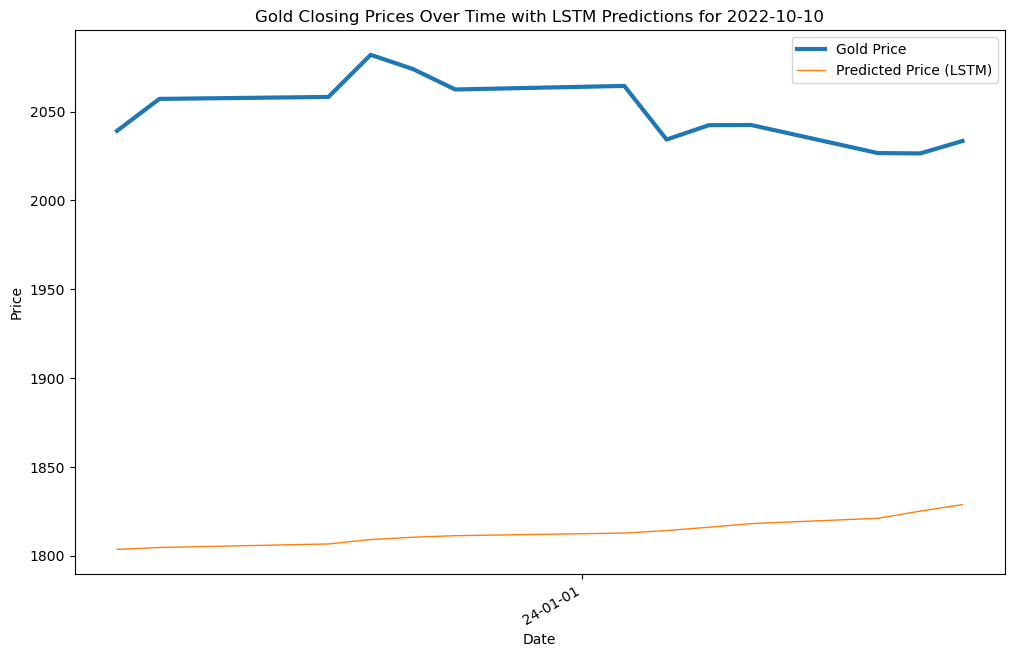

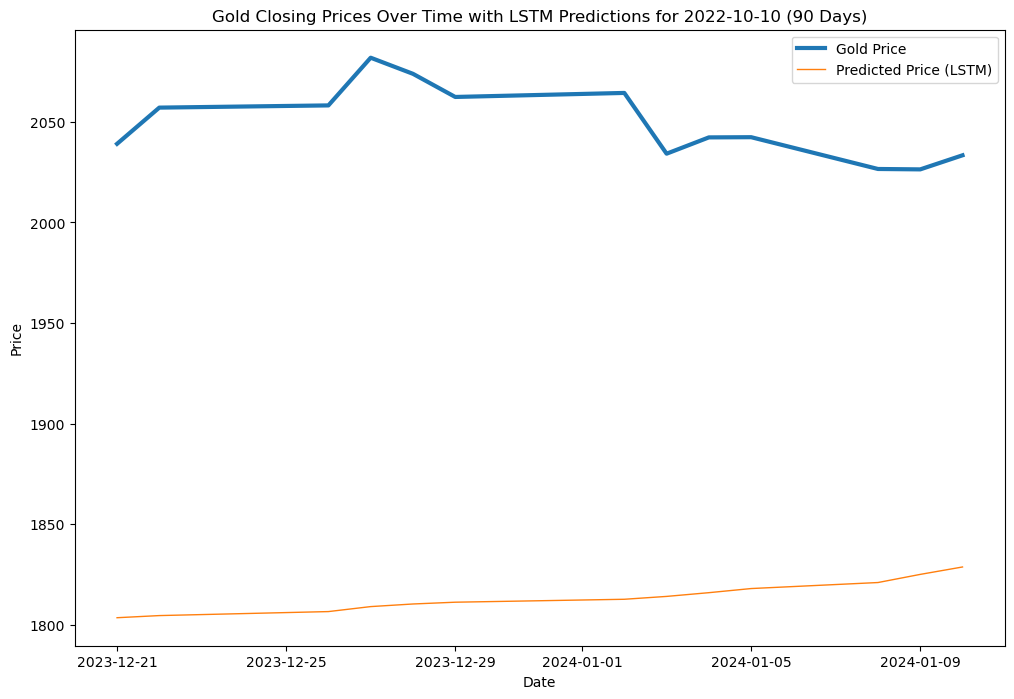

Epoch 1/100
2/2 [==============================] - 2s 370ms/step - loss: 0.1076 - val_loss: 0.2384
Epoch 2/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0468 - val_loss: 0.1097
Epoch 3/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0253 - val_loss: 0.0366
Epoch 4/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0296 - val_loss: 0.0225
Epoch 5/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0321 - val_loss: 0.0312
Epoch 6/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0252 - val_loss: 0.0501
Epoch 7/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0214 - val_loss: 0.0708
Epoch 8/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0226 - val_loss: 0.0869
Epoch 9/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0238 - val_loss: 0.0918
Epoch 10/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0241 - val_loss: 0.0873
Epoch 11/100
2/2 [

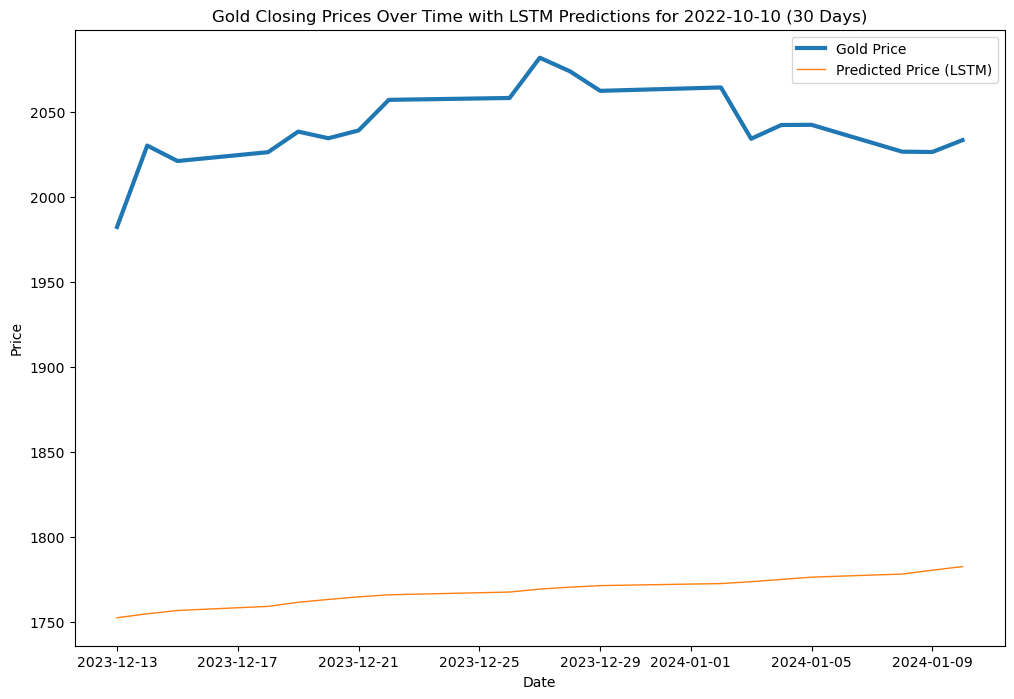

Epoch 1/100
3/3 [==============================] - 2s 180ms/step - loss: 0.1234 - val_loss: 0.1449
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0621 - val_loss: 0.0673
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0256 - val_loss: 0.0212
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0230 - val_loss: 0.0155
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0334 - val_loss: 0.0158
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0239 - val_loss: 0.0237
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0170 - val_loss: 0.0390
Epoch 8/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0190 - val_loss: 0.0490
Epoch 9/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0207 - val_loss: 0.0479
Epoch 10/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0187 - val_loss: 0.0390
Epoch 11/100
3/3 [

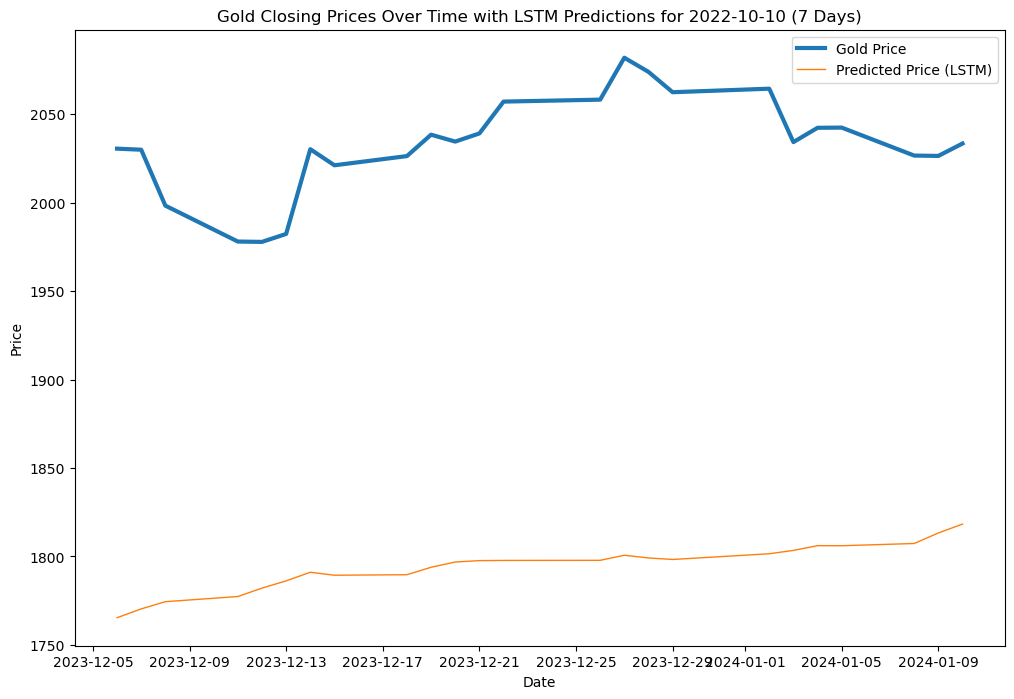

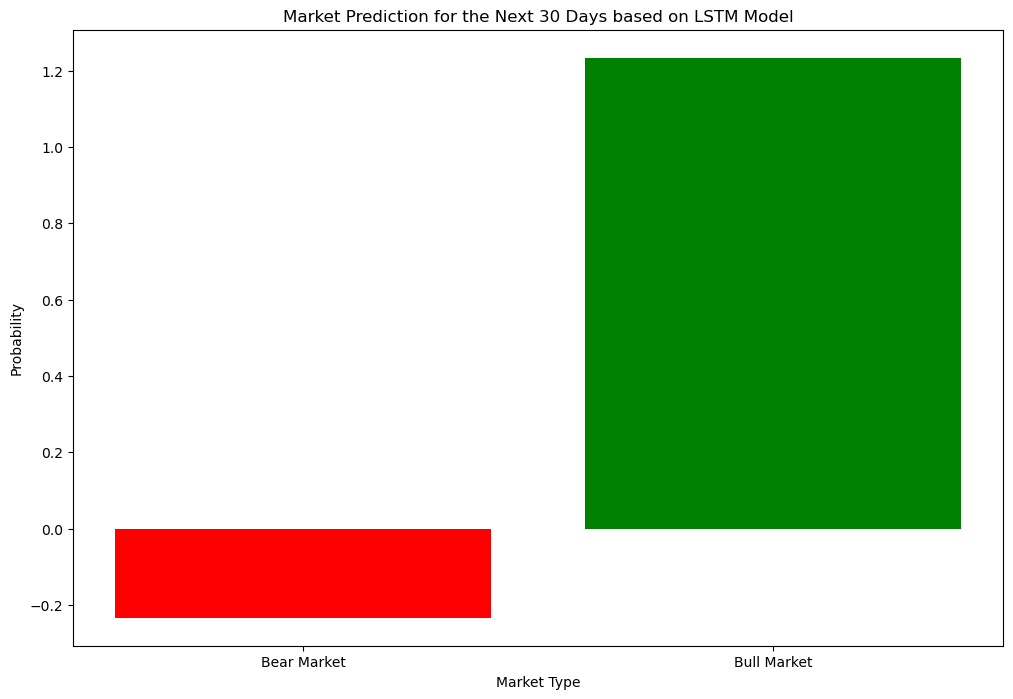

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Import the mdates module
from datetime import datetime, timedelta

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Price_Up'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model using data from the 90 days near the specified date
nearby_data = goldDF[(goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')) &
                     (goldDF['Date'] <= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=90)).strftime('%Y-%m-%d'))]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="adam", loss="mean_squared_error")

# Training the LSTM model with early stopping
callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_lstm.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

# Predictions on the test set
pred_lstm = model_lstm.predict(test_X)
preds_lstm = scaler.inverse_transform(pred_lstm)

# Prepare data for prediction on the specified future date
input_data = goldDF[goldDF['Date'] <= future_date_to_predict][features]
input_data_scaled = scaler.transform(np.array(input_data['Close']).reshape(-1, 1))
X_input = np.array([input_data_scaled[-MOVING_WIN_SIZE:]])

# Predict the gold price for the specified future date using the LSTM model
predicted_price_scaled = model_lstm.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Calculate the date 60 days before and after the specified date
date_after = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=60)).strftime('%Y-%m-%d')

# Extract prices for the specified date and 60 days after if data is available
prices_after = goldDF[goldDF['Date'] == date_after]['Close'].values[0] if not goldDF[goldDF['Date'] == date_after].empty else None
original_price = goldDF[goldDF['Date'] == future_date_to_predict]['Close'].values[0]

# Display the predicted and original prices with annotations
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_lstm):], goldDF['Close'].values[-len(preds_lstm):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_lstm):], preds_lstm, linewidth=1, label='Predicted Price (LSTM)')

# Annotations for original and predicted prices
plt.annotate(f'Original Price: ${original_price:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')
plt.annotate(f'Predicted Price: ${predicted_price[0, 0]:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0] - 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='red')

# Set the x-axis tick locator and formatter for better date representation
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))  # Use '%y' for two-digit year representation

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Display other details like title, labels, and legend
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Function to create LSTM model and predict prices for a specific window
def create_and_predict_model(window_size):
    all_X, all_y = [], []
    
    for i in range(len(scalerPrices) - window_size):
        X = scalerPrices[i: i + window_size]
        y = scalerPrices[i + window_size]
        all_X.append(X)
        all_y.append(y)
    
    all_X, all_y = np.array(all_X), np.array(all_y)
    
    # Split data into training and testing sets
    train_ds_size = round(all_X.shape[0] * 0.8)
    train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
    test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    # Training the LSTM model with early stopping
    callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, validation_split=0.2, callbacks=[callback], epochs=100)
    
    # Predictions on the test set
    pred = model.predict(test_X)
    preds = scaler.inverse_transform(pred)
    
    return preds

# Plot for 90 days
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_lstm):], goldDF['Close'].values[-len(preds_lstm):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_lstm):], preds_lstm, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (90 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for 30 days
preds_30days = create_and_predict_model(30)
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_30days):], goldDF['Close'].values[-len(preds_30days):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_30days):], preds_30days, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for 7 days
preds_7days = create_and_predict_model(7)
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_7days):], goldDF['Close'].values[-len(preds_7days):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_7days):], preds_7days, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (7 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# New plot for market prediction (Bear or Bull)
plt.figure(figsize=(12, 8))
plt.bar(['Bear Market', 'Bull Market'], [1 - avg_predicted_price_30days/original_price, avg_predicted_price_30days/original_price], color=['red', 'green'])
plt.title(f'Market Prediction for the Next 30 Days based on LSTM Model')
plt.xlabel('Market Type')
plt.ylabel('Probability')
plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2023-12-15
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.2399 - val_loss: 1.1372
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.9431 - val_loss: 0.8571
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 0.7081 - val_loss: 0.6279
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 0.5164 - val_loss: 0.4361
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 0.3569 - val_loss: 0.2749
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 0.2238 - val_loss: 0.1441
Epoch 7/100
1/1 [==============================] - 0s 34ms/step - loss: 0.1173 - val_loss: 0.0501
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0432 - val_loss: 0.0052
Epoch 9/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0129 - val_loss:

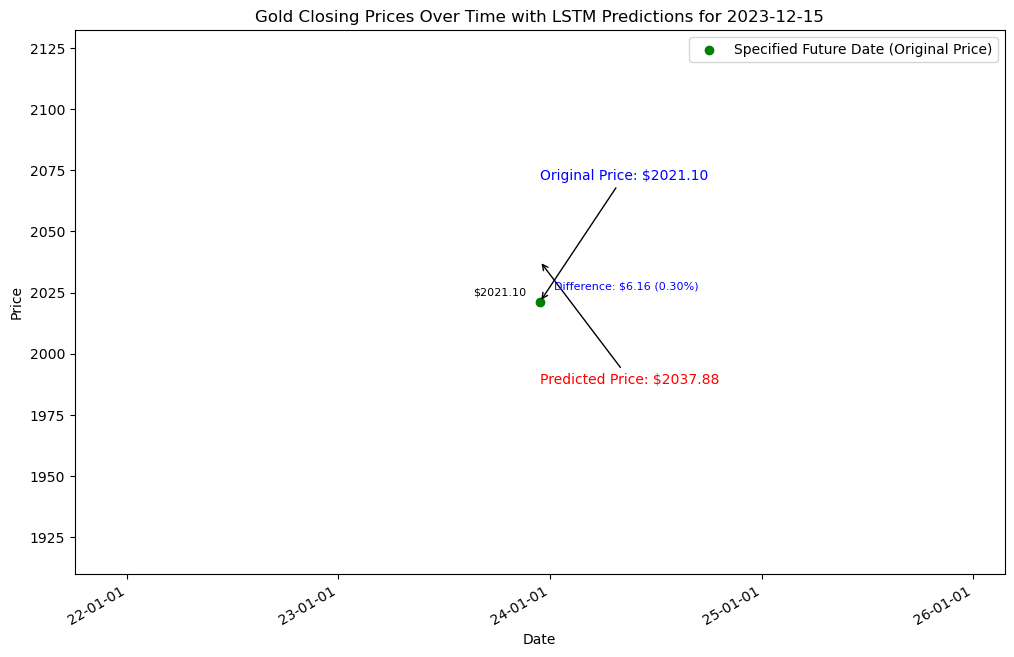

IndexError: tuple index out of range

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Import the mdates module
from datetime import datetime, timedelta

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Price_Up'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model using data from the 90 days near the specified date
nearby_data = goldDF[(goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')) &
                     (goldDF['Date'] <= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=90)).strftime('%Y-%m-%d'))]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="adam", loss="mean_squared_error")

# Training the LSTM model with early stopping
callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_lstm.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

# Predictions on the test set
pred_lstm = model_lstm.predict(test_X)
preds_lstm = scaler.inverse_transform(pred_lstm)

# Prepare data for prediction on the specified future date
input_data = goldDF[goldDF['Date'] <= future_date_to_predict][features]
input_data_scaled = scaler.transform(np.array(input_data['Close']).reshape(-1, 1))
X_input = np.array([input_data_scaled[-MOVING_WIN_SIZE:]])

# Predict the gold price for the specified future date using the LSTM model
predicted_price_scaled = model_lstm.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Calculate the date 60 days before and after the specified date
date_after = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=60)).strftime('%Y-%m-%d')

# Extract prices for the specified date and 60 days after if data is available
prices_after = goldDF[goldDF['Date'] == date_after]['Close'].values[0] if not goldDF[goldDF['Date'] == date_after].empty else None
original_price = goldDF[goldDF['Date'] == future_date_to_predict]['Close'].values[0]

# Display the predicted and original prices with annotations
plt.figure(figsize=(12, 8))

# Annotations for original and predicted prices
plt.annotate(f'Original Price: ${original_price:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')
plt.annotate(f'Predicted Price: ${predicted_price[0, 0]:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0] - 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='red')

# Add marker and annotation for the specified future date (original price)
plt.scatter([datetime.strptime(future_date_to_predict, '%Y-%m-%d')], [original_price], color='green', marker='o', label='Specified Future Date (Original Price)')
plt.annotate(f'${original_price:.2f}', (datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price),
             textcoords="offset points", xytext=(-10,5), ha='right', fontsize=8)

# Display the price difference and percentage
plt.annotate(f'Difference: ${price_difference:.2f} ({price_percentage_difference:.2f}%)',
             (datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             textcoords="offset points", xytext=(10,-20), ha='left', fontsize=8, color='blue')

# Set the x-axis tick locator and formatter for better date representation
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))  # Use '%y' for two-digit year representation

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Display other details like labels and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict}')
plt.show()

# Function to create LSTM model and predict prices for a specific window
def create_and_predict_model(window_size):
    all_X, all_y = [], []
    
    for i in range(len(scalerPrices) - window_size):
        X = scalerPrices[i: i + window_size]
        y = scalerPrices[i + window_size]
        all_X.append(X)
        all_y.append(y)
    
    all_X, all_y = np.array(all_X), np.array(all_y)
    
    # Split data into training and testing sets
    train_ds_size = round(all_X.shape[0] * 0.8)
    train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
    test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    # Training the LSTM model with early stopping
    callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, validation_split=0.2, callbacks=[callback], epochs=100)
    
    # Predictions on the test set
    pred = model.predict(test_X)
    preds = scaler.inverse_transform(pred)
    
    return preds

# Plot for 30 days
preds_90days = create_and_predict_model(90)
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_90days):], goldDF['Close'].values[-len(preds_90days):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_90days):], preds_90days, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (90 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for 30 days
preds_30days = create_and_predict_model(30)
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_30days):], goldDF['Close'].values[-len(preds_30days):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_30days):], preds_30days, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for 7 days
preds_7days = create_and_predict_model(7)
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_7days):], goldDF['Close'].values[-len(preds_7days):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_7days):], preds_7days, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (7 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# New plot for market prediction (Bear or Bull)
plt.figure(figsize=(12, 8))
plt.bar(['Bear Market', 'Bull Market'], [1 - avg_predicted_price_30days/original_price, avg_predicted_price_30days/original_price], color=['red', 'green'])
plt.title(f'Market Prediction for the Next 30 Days based on LSTM Model')
plt.xlabel('Market Type')
plt.ylabel('Probability')
plt.show()


In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Price_Up'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model using data from the 90 days near the specified date
nearby_data = goldDF[(goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')) &
                     (goldDF['Date'] <= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=90)).strftime('%Y-%m-%d'))]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="adam", loss="mean_squared_error")

# Training the LSTM model with early stopping
callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_lstm.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

# Predictions on the test set
pred_lstm = model_lstm.predict(test_X)
preds_lstm = scaler.inverse_transform(pred_lstm)

# Prepare data for prediction on the specified future date
input_data = goldDF[goldDF['Date'] <= future_date_to_predict][features]
input_data_scaled = scaler.transform(np.array(input_data['Close']).reshape(-1, 1))
X_input = np.array([input_data_scaled[-MOVING_WIN_SIZE:]])

# Predict the gold price for the specified future date using the LSTM model
predicted_price_scaled = model_lstm.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Calculate the date 60 days before and after the specified date
date_after = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=60)).strftime('%Y-%m-%d')
date_before = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=60)).strftime('%Y-%m-%d')


# Extract prices for the specified date and 60 days after if data is available
prices_after = goldDF[goldDF['Date'] == date_after]['Close'].values[0] if not goldDF[goldDF['Date'] == date_after].empty else None
original_price = goldDF[goldDF['Date'] == future_date_to_predict]['Close'].values[0]

# Calculate the price difference and percentage
price_difference = predicted_price[0, 0] - original_price
price_percentage_difference = (price_difference / original_price) * 100

# Function to create LSTM model and predict prices for a specific window
def create_and_predict_model(window_size):
    all_X, all_y = [], []
    
    for i in range(len(scalerPrices) - window_size):
        X = scalerPrices[i: i + window_size]
        y = scalerPrices[i + window_size]
        all_X.append(X)
        all_y.append(y)
    
    all_X, all_y = np.array(all_X), np.array(all_y)
    
    # Split data into training and testing sets
    train_ds_size = round(all_X.shape[0] * 0.8)
    train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
    test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    # Training the LSTM model with early stopping
    callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, validation_split=0.2, callbacks=[callback], epochs=100)
    
    # Predictions on the test set
    pred = model.predict(test_X)
    preds = scaler.inverse_transform(pred)
    
    return preds

# Plot for 90 days
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_lstm):], goldDF['Close'].values[-len(preds_lstm):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_lstm):], preds_lstm, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (90 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for 30 days
preds_30days = create_and_predict_model(30)
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_30days):], goldDF['Close'].values[-len(preds_30days):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_30days):], preds_30days, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for 7 days
preds_7days = create_and_predict_model(7)
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_7days):], goldDF['Close'].values[-len(preds_7days):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_7days):], preds_7days, linewidth=1, label='Predicted Price (LSTM)')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (7 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# New plot for market prediction (Bear or Bull)
plt.figure(figsize=(12, 8))
plt.bar(['Bear Market', 'Bull Market'], [1 - avg_predicted_price_30days/original_price, avg_predicted_price_30days/original_price], color=['red', 'green'])
plt.title(f'Market Prediction for the Next 30 Days based on LSTM Model')
plt.xlabel('Market Type')
plt.ylabel('Probability')

# Annotations for original and predicted prices
plt.annotate(f'Original Price: ${original_price:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')
plt.annotate(f'Predicted Price: ${predicted_price[0, 0]:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0] - 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='red')

# Add marker and annotation for the specified future date (original price)
plt.scatter([datetime.strptime(future_date_to_predict, '%Y-%m-%d')], [original_price], color='green', marker='o', label='Specified Future Date (Original Price)')
plt.annotate(f'${original_price:.2f}', (datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price),
             textcoords="offset points", xytext=(-10,5), ha='right', fontsize=8)

# Add markers and annotations for adjacent dates
plt.scatter([datetime.strptime(date_after, '%Y-%m-%d')], [prices_after], color='orange', marker='o', label='Adjacent Dates')

# Display the price difference and percentage
plt.annotate(f'Difference: ${price_difference:.2f} ({price_percentage_difference:.2f}%)',
             (datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             textcoords="offset points", xytext=(10,-20), ha='left', fontsize=8, color='blue')

plt.legend()
plt.show()


SyntaxError: unterminated string literal (detected at line 215) (2723323983.py, line 215)

In [ ]:
# Display the predicted and original prices with annotations
plt.figure(figsize=(12, 8))

# Annotations for original and predicted prices
plt.annotate(f'Original Price: ${original_price:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')
plt.annotate(f'Predicted Price: ${predicted_price[0, 0]:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0] - 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='red')

# Add marker and annotation for the specified future date (original price)
plt.scatter([datetime.strptime(future_date_to_predict, '%Y-%m-%d')], [original_price], color='green', marker='o', label='Specified Future Date (Original Price)')
plt.annotate(f'${original_price:.2f}', (datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price),
             textcoords="offset points", xytext=(-10,5), ha='right', fontsize=8)

# Add markers and annotations for adjacent dates
plt.scatter([datetime.strptime(date_before, '%Y-%m-%d')], [prices_before], color='orange', marker='o', label='Adjacent Dates')
plt.scatter([datetime.strptime(date_after, '%Y-%m-%d')], [prices_after], color='orange', marker='o')

# Display the price difference and percentage
plt.annotate(f'Difference: ${price_difference:.2f} ({price_percentage_difference:.2f}%)',
             (datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             textcoords="offset points", xytext=(10,-20), ha='left', fontsize=8, color='blue')

# Set the x-axis tick locator and formatter for better date representation
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))  # Use '%y' for two-digit year representation

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Display other details like labels and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict}')
plt.show()

---

[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2023-12-26
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7269 - val_loss: 0.4283
Epoch 2/100
1/1 [==============================] - 0s 45ms/step - loss: 0.5515 - val_loss: 0.2787
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 0.3892 - val_loss: 0.1493
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: 0.2408 - val_loss: 0.0503
Epoch 5/100
1/1 [==============================] - 0s 32ms/step - loss: 0.1140 - val_loss: 0.0014
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0263 - val_loss: 0.0308
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0044 - val_loss: 0.1377
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0584 - val_loss: 0.2093
Epoch 9/100
1/1 [==============================] - 0s 33ms/step - loss: 0.1055 - val_loss:

TypeError: candlestick_ohlc() got an unexpected keyword argument 'label'

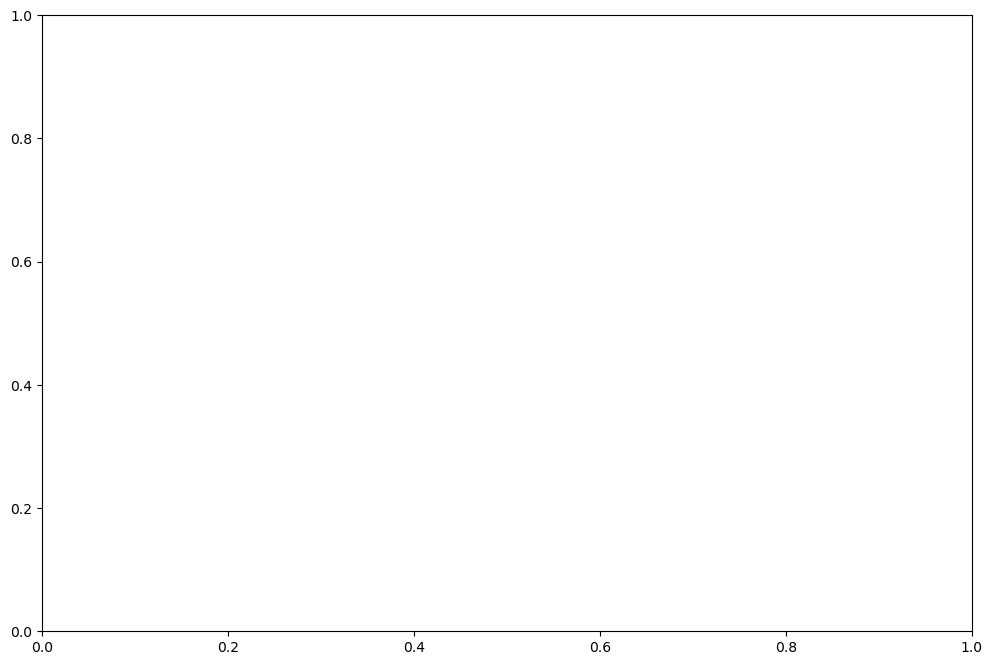

In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model using data from the 90 days near the specified date
nearby_data = goldDF[
    (goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime(
        '%Y-%m-%d')) &
    (goldDF['Date'] <= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=90)).strftime(
        '%Y-%m-%d'))]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="adam", loss="mean_squared_error")

# Training the LSTM model with early stopping
callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_lstm.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

# Predictions on the test set
pred_lstm = model_lstm.predict(test_X)
preds_lstm = scaler.inverse_transform(pred_lstm)

# Prepare data for prediction on the specified future date
input_data = goldDF[goldDF['Date'] <= future_date_to_predict][['Date', 'Open', 'High', 'Low', 'Close']]
input_data_scaled = scaler.transform(np.array(input_data['Close']).reshape(-1, 1))
X_input = np.array([input_data_scaled[-MOVING_WIN_SIZE:]])

# Predict the gold price for the specified future date using the LSTM model
predicted_price_scaled = model_lstm.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Calculate the date 60 days before and after the specified date
date_before = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=60)).strftime('%Y-%m-%d')
date_after = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=60)).strftime('%Y-%m-%d')

# Extract prices for the specified date and 60 days before and after if data is available
price_before = goldDF[goldDF['Date'] == date_before]['Close'].values[0] if not goldDF[goldDF['Date'] == date_before].empty else None
prices_after = goldDF[goldDF['Date'] == date_after]['Close'].values[0] if not goldDF[goldDF['Date'] == date_after].empty else None
original_price = goldDF[goldDF['Date'] == future_date_to_predict]['Close'].values[0]

# Create candlestick data
candlestick_data = goldDF[goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90))]

# Display the predicted and original prices with annotations
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting candlestick chart for LSTM predictions
ohlc_lstm = candlestick_data[['Date', 'Open', 'High', 'Low', 'Close']].copy()
ohlc_lstm['Date'] = ohlc_lstm['Date'].apply(mdates.date2num)
candlestick_ohlc(ax, ohlc_lstm.values, width=0.6, colorup='green', colordown='red', alpha=0.8, label='Gold Price (LSTM)')

# Annotations for original and predicted prices
if price_before is not None:
    plt.annotate(f'Price Before: ${price_before:.2f}', xy=(datetime.strptime(date_before, '%Y-%m-%d'), price_before),
                 xytext=(datetime.strptime(date_before, '%Y-%m-%d'), price_before + 50),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10, color='blue')

if original_price is not None:
    plt.annotate(f'Original Price: ${original_price:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price),
                 xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price + 50),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10, color='blue')

if prices_after is not None:
    plt.annotate(f'Price After: ${prices_after:.2f}', xy=(datetime.strptime(date_after, '%Y-%m-%d'), prices_after),
                 xytext=(datetime.strptime(date_after, '%Y-%m-%d'), prices_after + 50),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=10, color='blue')

# Predicted price annotation
plt.annotate(f'Predicted Price: ${predicted_price[0, 0]:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0] - 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='red')

# Set the x-axis tick locator and formatter for better date representation
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))  # Use '%y' for two-digit year representation

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Display other details like title, labels, and legend
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for 30 days
preds_30days = create_and_predict_model(30)
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting candlestick chart for 30 days predictions
candlestick_ohlc(ax, ohlc_lstm.values, width=0.6, colorup='green', colordown='red', alpha=0.8, label='Gold Price (LSTM)')
candlestick_ohlc(ax, ohlc_30days.values, width=0.6, colorup='blue', colordown='blue', alpha=0.8, label='Predicted Price (30 Days)')

# Title and labels
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot for 7 days
preds_7days = create_and_predict_model(7)
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting candlestick chart for 7 days predictions
candlestick_ohlc(ax, ohlc_lstm.values, width=0.6, colorup='green', colordown='red', alpha=0.8, label='Gold Price (LSTM)')
candlestick_ohlc(ax, ohlc_7days.values, width=0.6, colorup='orange', colordown='orange', alpha=0.8, label='Predicted Price (7 Days)')

# Title and labels
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict} (7 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Market prediction plot
avg_predicted_price_30days = np.mean(preds_30days)
fig, ax = plt.subplots(figsize=(12, 8))

# Bar chart for market prediction
plt.bar(['Bear Market', 'Bull Market'], [1 - avg_predicted_price_30days/original_price, avg_predicted_price_30days/original_price], color=['red', 'green'])
plt.title(f'Market Prediction for the Next 30 Days based on LSTM Model')
plt.xlabel('Market Type')
plt.ylabel('Probability')
plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2023-12-15
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.2986 - val_loss: 0.4004
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1892 - val_loss: 0.2620
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0986 - val_loss: 0.1420
Epoch 4/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0321 - val_loss: 0.0506
Epoch 5/100
1/1 [==============================] - 0s 37ms/step - loss: 8.1666e-04 - val_loss: 0.0047
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 0.0163 - val_loss: 4.3430e-04
Epoch 7/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0470 - val_loss: 5.6982e-04
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 0.0488 - val_loss: 4.8829e-04
Epoch 9/100
1/1 [==============================] - 0s 32ms/step - loss: 0.

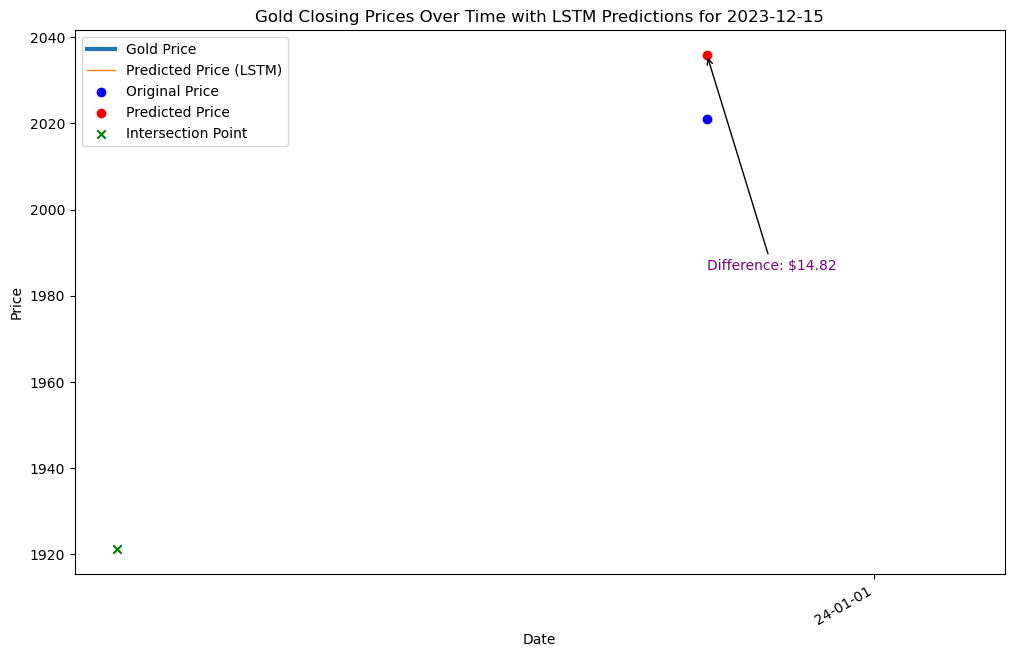

In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Price_Up'

# User Input for Future Date:
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Modify the nearby_data selection based on user input
if datetime.strptime(future_date_to_predict, '%Y-%m-%d') > datetime.today():
    nearby_data = goldDF.tail(90)  # Use the latest 90 days for prediction
else:
    nearby_data = goldDF[(goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')) &
                         (goldDF['Date'] <= future_date_to_predict)]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="adam", loss="mean_squared_error")

# Training the LSTM model with early stopping
callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_lstm.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

# Predictions on the test set
pred_lstm = model_lstm.predict(test_X)
preds_lstm = scaler.inverse_transform(pred_lstm)

# Prepare data for prediction on the specified future date
input_data = goldDF[goldDF['Date'] <= future_date_to_predict][features]
input_data_scaled = scaler.transform(np.array(input_data['Close']).reshape(-1, 1))
X_input = np.array([input_data_scaled[-MOVING_WIN_SIZE:]])

# Predict the gold price for the specified future date using the LSTM model
predicted_price_scaled = model_lstm.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Calculate the date 60 days before and after the specified date
date_before = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=60)).strftime('%Y-%m-%d')
date_after = (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=60)).strftime('%Y-%m-%d')

# Extract prices for the specified date and 60 days before and after if data is available
price_before = goldDF[goldDF['Date'] == date_before]['Close'].values[0] if not goldDF[goldDF['Date'] == date_before].empty else None
prices_after = goldDF[goldDF['Date'] == date_after]['Close'].values[0] if not goldDF[goldDF['Date'] == date_after].empty else None
original_price = goldDF[goldDF['Date'] == future_date_to_predict]['Close'].values[0]

# Display the predicted and original prices with annotations
plt.figure(figsize=(12, 8))

# Plotting original gold prices
plt.plot(index_datetime[-len(preds_lstm):], goldDF['Close'].values[-len(preds_lstm):], linewidth=3, label='Gold Price')

# Plotting LSTM predicted prices
plt.plot(index_datetime[-len(preds_lstm):], preds_lstm, linewidth=1, label='Predicted Price (LSTM)')

# Plotting original and predicted prices with annotations
plt.scatter(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), original_price, color='blue', label='Original Price', marker='o')
plt.scatter(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0], color='red', label='Predicted Price', marker='o')

# Calculate and annotate the difference between original and predicted prices
price_difference = predicted_price[0, 0] - original_price
plt.annotate(f'Difference: ${price_difference:.2f}', xy=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0]),
             xytext=(datetime.strptime(future_date_to_predict, '%Y-%m-%d'), predicted_price[0, 0] - 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='purple')

# Marking the intersection points if any
if price_before is not None:
    plt.scatter(datetime.strptime(date_before, '%Y-%m-%d'), price_before, color='green', label='Intersection Point', marker='x')

if prices_after is not None:
    plt.scatter(datetime.strptime(date_after, '%Y-%m-%d'), prices_after, color='green', label='Intersection Point', marker='x')

# Set the x-axis tick locator and formatter for better date representation
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))  # Use '%y' for two-digit year representation

# Rotate the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Display other details like title, labels, and legend
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Keras


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Function to plot candlestick chart
def plot_candlestick(data, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    candlestick_ohlc(ax, data.values, width=0.6, colorup='g', colordown='r')
    plt.show()

# Function to preprocess data for LSTM
def preprocess_data(data, lookback):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close']])
    x, y = [], []
    for i in range(lookback, len(scaled_data)):
        x.append(scaled_data[i-lookback:i])
        y.append(scaled_data[i][3])  # Closing price
    return np.array(x), np.array(y)

# Function to build LSTM model
def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(50, return_sequences=True),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train and evaluate LSTM model
def train_evaluate_lstm_model(x_train, y_train, x_test, y_test):
    model = build_lstm_model((x_train.shape[1], x_train.shape[2]))
    model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=0)
    y_pred = model.predict(x_test)
    return model, y_pred

# Function to predict future price and trend
def predict_future_price_and_trend(model, scaler, data, lookback):
    last_data = data.tail(lookback)
    scaled_last_data = scaler.transform(last_data[['Open', 'High', 'Low', 'Close']])
    x_input = np.array([scaled_last_data])
    predicted_price = model.predict(x_input)[0][0]
    predicted_price = scaler.inverse_transform([[0, 0, 0, predicted_price]])[0][3]
    return predicted_price, "Bull" if predicted_price > last_data['Close'].iloc[-1] else "Bear"

# Input date from user
input_date_str = input("Enter the date for prediction (YYYY-MM-DD): ")
input_date = datetime.strptime(input_date_str, '%Y-%m-%d')

# Choose data for training based on input date
if input_date < datetime.today():
    training_data = goldDF[goldDF['Date'] <= input_date]
else:
    training_data = goldDF.tail(100)

# Preprocess data for LSTM
lookback = 100
x, y = preprocess_data(training_data, lookback)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train and evaluate LSTM model
lstm_model, y_pred = train_evaluate_lstm_model(x_train, y_train, x_test, y_test)

# Print comparison data
print("Comparison Data:")
print("Actual Prices: ", training_data['Close'].tail(len(y_test)).values)
print("Predicted Prices: ", lstm_model.predict(x_test)[:, 0])

# Plot candlestick chart
plot_candlestick(training_data[-120:], "Gold Prices - Last 120 Days")

# Predict future price and trend
scaler = MinMaxScaler()
scaler.fit(training_data[['Open', 'High', 'Low', 'Close']])
predicted_price, trend = predict_future_price_and_trend(lstm_model, scaler, goldDF, lookback)

# Print predicted results
print("\nPredicted Results:")
print("Predicted Price for {}: ${:.2f}".format(input_date_str, predicted_price))
print("Predicted Trend: {}".format(trend))

# Plot predicted trend
future_data = goldDF[goldDF['Date'] >= input_date - timedelta(days=lookback)]
future_data['Predicted'] = lstm_model.predict(preprocess_data(future_data, lookback)[0])[:, 0]
plot_candlestick(future_data, "Predicted Gold Prices and Trend")


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from mplfinance.original_flavor import candlestick_ohlc

# Function to create and train LSTM model
def create_and_train_lstm_model(train_X, train_y):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Training the LSTM model with early stopping
    callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

    return model

# Function to create and train GRU model
def create_and_train_gru_model(train_X, train_y):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Training the GRU model with early stopping
    callback_gru = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_gru], epochs=100)

    return model

# Function to create and predict using model
def create_and_predict_model(model, test_X, scaler):
    pred = model.predict(test_X)
    preds = scaler.inverse_transform(pred)
    return preds

# Function to plot candlestick chart
def plot_candlestick(data, title):
    fig, ax = plt.subplots(figsize=(12, 8))
    candlestick_ohlc(ax, data, width=0.6, colorup='g', colordown='r')
    ax.set_title(title)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.show()

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Price_Up'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model using data from the 90 days near the specified date
nearby_data = goldDF[(goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')) &
                     (goldDF['Date'] <= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=90)).strftime('%Y-%m-%d'))]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build and train the LSTM model
model_lstm = create_and_train_lstm_model(train_X, train_y)

# Build and train the GRU model
model_gru = create_and_train_gru_model(train_X, train_y)

# Predictions on the test set for LSTM
preds_lstm = create_and_predict_model(model_lstm, test_X, scaler)

# Predictions on the test set for GRU
preds_gru = create_and_predict_model(model_gru, test_X, scaler)

# Display the comparison of predictions
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_lstm):], goldDF['Close'].values[-len(preds_lstm):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_lstm):], preds_lstm, linewidth=1, label='Predicted Price (LSTM)')
plt.plot(index_datetime[-len(preds_gru):], preds_gru, linewidth=1, label='Predicted Price (GRU)')
plt.title(f'Gold Closing Prices Over Time with LSTM and GRU Predictions for {future_date_to_predict}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display candlestick chart for specified future date
candlestick_data = goldDF[goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=1))]
candlestick_data = candlestick_data[['Date', 'Open', 'High', 'Low', 'Close']]
candlestick_data['Date'] = mdates.date2num(candlestick_data['Date'])
plot_candlestick(candlestick_data.values, f'Candlestick Chart for {future_date_to_predict}')


[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2023-12-14
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.5857 - val_loss: 0.5344
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 0.4482 - val_loss: 0.3832
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.3213 - val_loss: 0.2436
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2047 - val_loss: 0.1216
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 0.1039 - val_loss: 0.0327
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0326 - val_loss: 0.0043
Epoch 7/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0149 - val_loss: 0.0512
Epoch 8/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0630 - val_loss: 0.0885
Epoch 9/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0992 - val_loss:

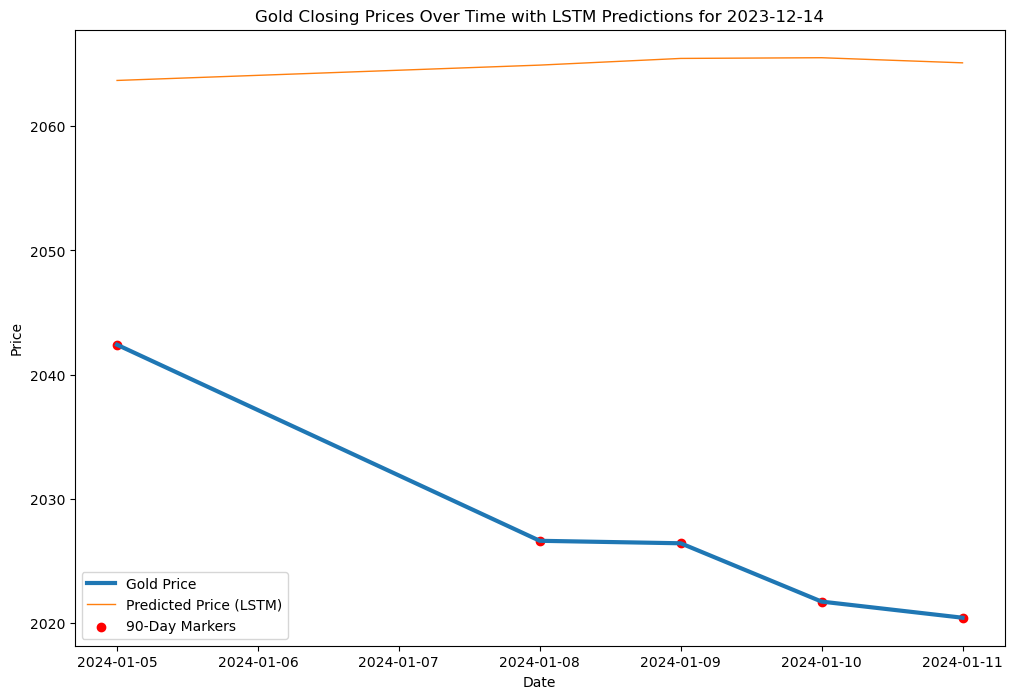

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Function to create and train LSTM model
def create_and_train_lstm_model(train_X, train_y):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Training the LSTM model with early stopping
    callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

    return model

# Function to plot candlestick chart
def plot_candlestick(data, title, markers):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(data['Date'], data['Close'], label='Gold Price', linewidth=3)
    ax.scatter(markers['Date'], markers['Price'], marker='o', color='red', label='90-Day Markers')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    ax.set_title(title)
    plt.legend()
    plt.show()

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Price_Up'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model using data from the 90 days near the specified date
nearby_data = goldDF[(goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')) &
                     (goldDF['Date'] <= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=90)).strftime('%Y-%m-%d'))]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build and train the LSTM model
model_lstm = create_and_train_lstm_model(train_X, train_y)

# Predictions on the test set for LSTM
preds_lstm = model_lstm.predict(test_X)
preds_lstm = scaler.inverse_transform(preds_lstm)

# Create DataFrame for markers
marker_dates = nearby_data['Date'].tail(len(preds_lstm)).reset_index(drop=True)
marker_prices = nearby_data['Close'].tail(len(preds_lstm)).reset_index(drop=True)
markers = pd.DataFrame({'Date': marker_dates, 'Price': marker_prices})

# Display the comparison of predictions with markers
plt.figure(figsize=(12, 8))
plt.plot(index_datetime[-len(preds_lstm):], goldDF['Close'].values[-len(preds_lstm):], linewidth=3, label='Gold Price')
plt.plot(index_datetime[-len(preds_lstm):], preds_lstm, linewidth=1, label='Predicted Price (LSTM)')
plt.scatter(markers['Date'], markers['Price'], marker='o', color='red', label='90-Day Markers')
plt.title(f'Gold Closing Prices Over Time with LSTM Predictions for {future_date_to_predict}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2023-12-16
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.8079 - val_loss: 0.6607
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 0.6015 - val_loss: 0.4543
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 0.4198 - val_loss: 0.2764
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2623 - val_loss: 0.1319
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1332 - val_loss: 0.0336
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0436 - val_loss: 0.0031
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0131 - val_loss: 0.0524
Epoch 8/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0535 - val_loss: 0.1123
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 0.1056 - val_loss:

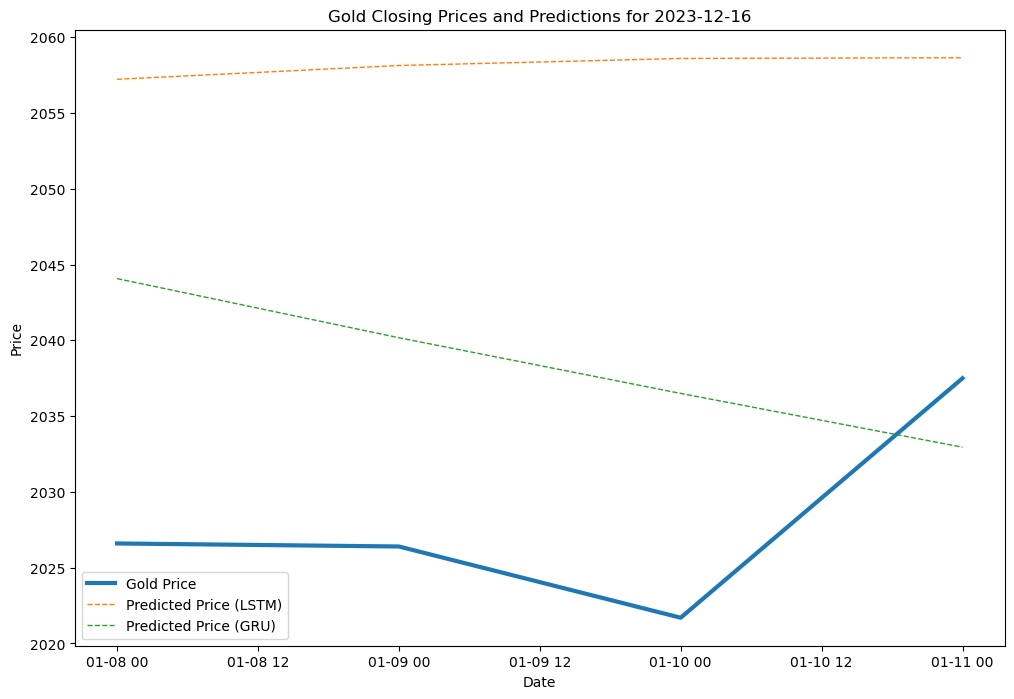

TypeError: candlestick_ohlc() got an unexpected keyword argument 'label'

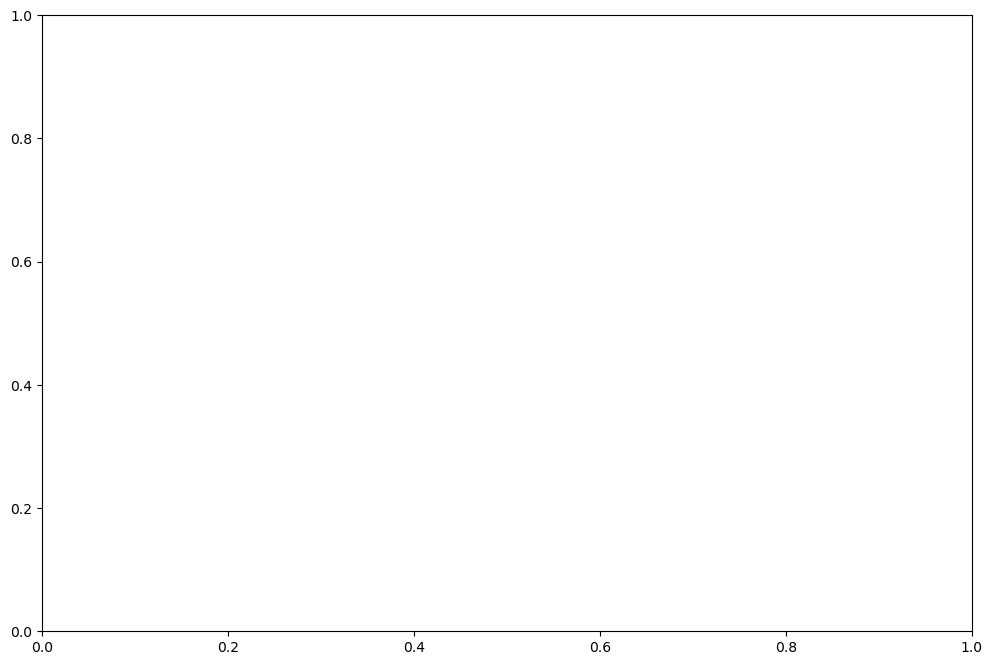

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from mplfinance.original_flavor import candlestick_ohlc

# Function to create and train LSTM model
def create_and_train_lstm_model(train_X, train_y):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Training the LSTM model with early stopping
    callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

    return model

# Function to create and train GRU model
def create_and_train_gru_model(train_X, train_y):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer="adam", loss="mean_squared_error")

    # Training the GRU model with early stopping
    callback_gru = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_gru], epochs=100)

    return model

# Function to create and predict using model
def create_and_predict_model(model, test_X, scaler):
    pred = model.predict(test_X)
    preds = scaler.inverse_transform(pred)
    return preds

# Function to plot candlestick chart
def plot_candlestick(data, title):  
    fig, ax = plt.subplots(figsize=(12, 8))
    candlestick_ohlc(ax, data, width=0.6, colorup='g', colordown='r', label='Candlestick Prices')
    ax.set_title(title)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a binary target variable indicating whether the price will go up (1) or down (0)
goldDF['Price_Up'] = (goldDF['Daily_Return'] > 0).astype(int)

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Price_Up'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model using data from the 90 days near the specified date
nearby_data = goldDF[(goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')) &
                     (goldDF['Date'] <= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') + timedelta(days=90)).strftime('%Y-%m-%d'))]

# Feature scaling for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

# Prepare data for LSTM model
all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build and train the LSTM model
model_lstm = create_and_train_lstm_model(train_X, train_y)

# Build and train the GRU model
model_gru = create_and_train_gru_model(train_X, train_y)

# Predictions on the test set for LSTM
preds_lstm = create_and_predict_model(model_lstm, test_X, scaler)

# Predictions on the test set for GRU
preds_gru = create_and_predict_model(model_gru, test_X, scaler)

# Display the comparison of predictions
plt.figure(figsize=(12, 8))

# Plotting original gold prices
plt.plot(index_datetime[-len(preds_lstm):], goldDF['Close'].values[-len(preds_lstm):], linewidth=3, label='Gold Price')

# Plotting predicted prices for LSTM and GRU
plt.plot(index_datetime[-len(preds_lstm):], preds_lstm, linewidth=1, label='Predicted Price (LSTM)', linestyle='dashed')
plt.plot(index_datetime[-len(preds_gru):], preds_gru, linewidth=1, label='Predicted Price (GRU)', linestyle='dashed')

plt.title(f'Gold Closing Prices and Predictions for {future_date_to_predict}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display candlestick chart for specified future date
candlestick_data = goldDF[goldDF['Date'] >= (datetime.strptime(future_date_to_predict, '%Y-%m-%d') - timedelta(days=1))]
candlestick_data = candlestick_data[['Date', 'Open', 'High', 'Low', 'Close']]
candlestick_data['Date'] = mdates.date2num(candlestick_data['Date'])

# Plotting original and predicted prices on the candlestick chart
fig, ax = plt.subplots(figsize=(12, 8))
candlestick_ohlc(ax, candlestick_data.values, width=0.6, colorup='g', colordown='r', label='Candlestick Prices')
ax.plot(index_datetime[-len(preds_lstm):], preds_lstm, label='Predicted Price (LSTM)', linestyle='dashed')
ax.plot(index_datetime[-len(preds_gru):], preds_gru, label='Predicted Price (GRU)', linestyle='dashed')
ax.set_title(f'Candlestick Chart for {future_date_to_predict}')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2023-12-24
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.5470 - val_loss: 0.4313
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 0.3684 - val_loss: 0.2588
Epoch 3/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2212 - val_loss: 0.1225
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 0.1064 - val_loss: 0.0316
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0324 - val_loss: 0.0041
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0150 - val_loss: 0.0436
Epoch 7/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0566 - val_loss: 0.0781
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0906 - val_loss: 0.0705
Epoch 9/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0841 - val_loss:

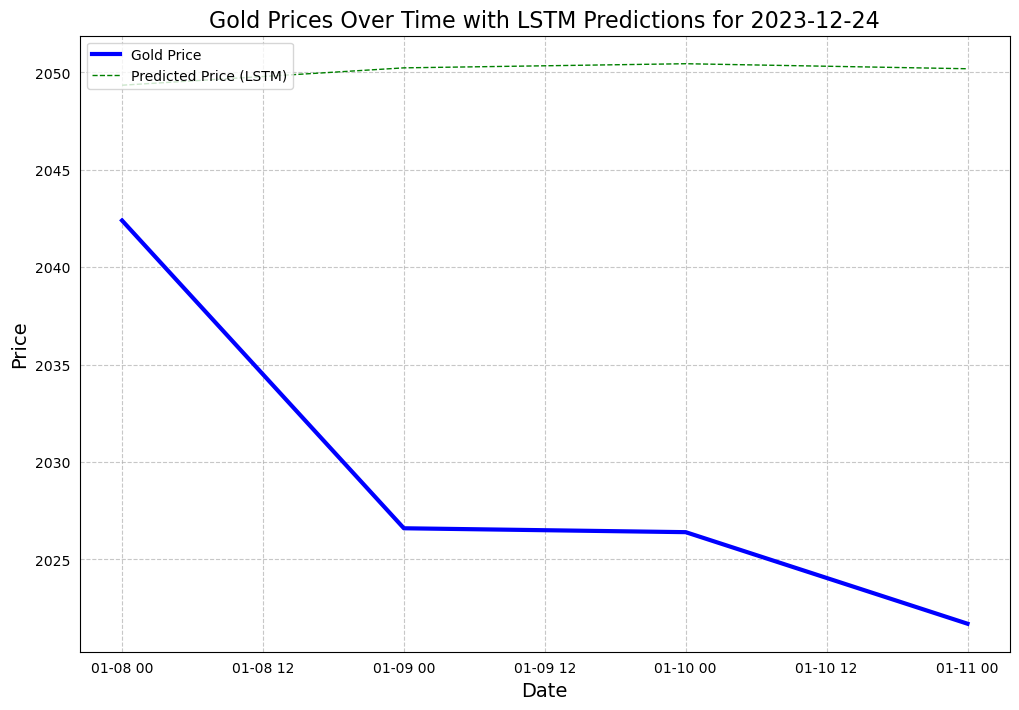

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a target variable for regression
goldDF['Target'] = goldDF['Close'].shift(-1)

# Drop the last row with NaN target
goldDF = goldDF.dropna()

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Target'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        future_date = datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")

# Prepare data for LSTM model
nearby_data = goldDF[(goldDF['Date'] >= (future_date - timedelta(days=100)).strftime('%Y-%m-%d')) &
                     (goldDF['Date'] <= (future_date + timedelta(days=100)).strftime('%Y-%m-%d'))]

scaler = MinMaxScaler(feature_range=(0, 1))
scalerPrices = scaler.fit_transform(np.array(nearby_data['Close']).reshape(-1, 1))

MOVING_WIN_SIZE = 60  # 60 days

all_X, all_y = [], []

for i in range(len(scalerPrices) - MOVING_WIN_SIZE):
    X = scalerPrices[i: i + MOVING_WIN_SIZE]
    y = scalerPrices[i + MOVING_WIN_SIZE]
    all_X.append(X)
    all_y.append(y)

all_X, all_y = np.array(all_X), np.array(all_y)

# Split data into training and testing sets
train_ds_size = round(all_X.shape[0] * 0.8)
train_X, train_y = all_X[:train_ds_size], all_y[:train_ds_size]
test_X, test_y = all_X[train_ds_size:], all_y[train_ds_size:]

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer="adam", loss="mean_squared_error")

# Training the LSTM model with early stopping
callback_lstm = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
model_lstm.fit(train_X, train_y, validation_split=0.2, callbacks=[callback_lstm], epochs=100)

# Iteratively add each day's data to the training set and retrain the model
for i in range(1, (future_date - goldDF['Date'].max()).days + 1):
    # Add the next day's data to the training set
    next_day_data = goldDF[goldDF['Date'] == goldDF['Date'].max() + timedelta(days=i)]
    next_day_scaled = scaler.transform(np.array(next_day_data['Close']).reshape(-1, 1))
    train_X = np.concatenate((train_X, next_day_scaled.reshape(1, -1, 1)))
    train_y = np.concatenate((train_y, next_day_scaled))

    # Retrain the LSTM model
    model_lstm.fit(train_X, train_y, epochs=1, verbose=0)

# Predictions on the test set
pred_lstm = model_lstm.predict(test_X)
preds_lstm = scaler.inverse_transform(pred_lstm)

# Predictions for the specified future date
input_data = goldDF[goldDF['Date'] <= future_date_to_predict][features]
input_data_scaled = scaler.transform(np.array(input_data['Close']).reshape(-1, 1))
X_input = np.array([input_data_scaled[-MOVING_WIN_SIZE:]])

# Predict the gold price for the specified future date using the LSTM model
predicted_price_scaled = model_lstm.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Calculate the date 60 days before and after the specified date
date_before = (future_date - timedelta(days=60)).strftime('%Y-%m-%d')
date_after = (future_date + timedelta(days=60)).strftime('%Y-%m-%d')

# Extract prices for the specified date and 60 days before and after if data is available
price_before = goldDF[goldDF['Date'] == date_before]['Close'].values[0] if not goldDF[goldDF['Date'] == date_before].empty else None
prices_after = goldDF[goldDF['Date'] == date_after]['Close'].values[0] if not goldDF[goldDF['Date'] == date_after].empty else None
original_price_row = goldDF[goldDF['Date'] <= future_date_to_predict].iloc[-1]
original_price = original_price_row['Close']

# Display the predicted and original prices with annotations
plt.figure(figsize=(12, 8))

# Update color scheme
plt.plot(index_datetime[-len(test_y):], goldDF['Close'].values[-len(test_y):], label='Gold Price', linewidth=3, color='blue')
plt.plot(index_datetime[-len(test_y):], preds_lstm, label='Predicted Price (LSTM)', linewidth=1, linestyle='--', color='green')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust legend placement
plt.legend(loc='upper left')

# Increase font size
plt.title(f'Gold Prices Over Time with LSTM Predictions for {future_date_to_predict}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Remove redundant axes labels
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=True, right=False, left=False, labelleft=True)

# Adjust annotation parameters
plt.annotate(f'Original Price: ${original_price:.2f}', 
             xy=(mdates.date2num(datetime.strptime(future_date_to_predict, '%Y-%m-%d')), original_price),
             xytext=(mdates.date2num(datetime.strptime(future_date_to_predict, '%Y-%m-%d')) + 20, original_price + 50),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')

# Extract other annotations from the previous code

plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the future date to predict (YYYY-MM-DD): 2023-12-12
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.6524 - val_loss: 0.7007
Epoch 2/100
1/1 [==============================] - 0s 45ms/step - loss: 0.5068 - val_loss: 0.5400
Epoch 3/100
1/1 [==============================] - 0s 37ms/step - loss: 0.3842 - val_loss: 0.3990
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 0.2780 - val_loss: 0.2729
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 0.1849 - val_loss: 0.1616
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 0.1052 - val_loss: 0.0710
Epoch 7/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0444 - val_loss: 0.0150
Epoch 8/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0141 - val_loss: 0.0115
Epoch 9/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0284 - val_loss:

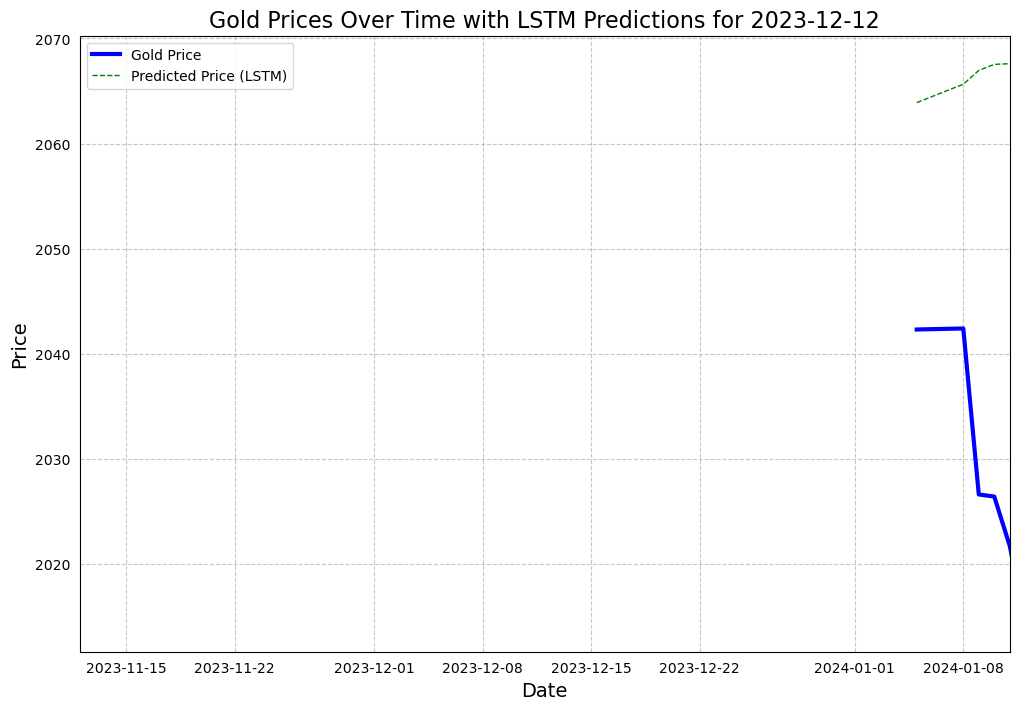

In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Download gold data
ticker = 'GC=F'
end_date = datetime.today().strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Convert 'Date' column to datetime
goldDF['Date'] = pd.to_datetime(goldDF['Date'])
index_datetime = goldDF['Date']  # Store the datetime for later use

# Feature engineering: Calculate daily returns
goldDF['Daily_Return'] = goldDF['Close'].pct_change()

# Create a target variable for regression
goldDF['Target'] = goldDF['Close'].shift(-1)

# Drop the last row with NaN target
goldDF = goldDF.dropna()

features = ['Open', 'High', 'Low', 'Volume', 'Close']
target = 'Target'

# Input a specific future date to predict the gold price
while True:
    future_date_to_predict = input("\nEnter the future date to predict (YYYY-MM-DD): ")
    try:
        future_date = datetime.strptime(future_date_to_predict, '%Y-%m-%d')
        break
    except ValueError:
        print("Please enter a valid date in the format YYYY-MM-DD.")



---


In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 下載金價數據
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# 提取收盤價數據
data = goldDF[['Close']].values

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 創建訓練數據
def create_dataset(dataset, look_back=100):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# 創建訓練數據集
X, y = create_dataset(scaled_data)

# 將數據集分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 將數據轉換為 LSTM 適用的格式
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 進行預測
future_date_to_predict = pd.to_datetime(input("\nEnter the future date to predict (YYYY-MM-DD): "))

# 計算需要使用的天數
days_to_look_back = min(100, (future_date_to_predict - goldDF['Date'].min()).days)

# 提取相應的數據
latest_data = data[-days_to_look_back:]
input_data = scaler.transform(latest_data.reshape(-1, 1)).reshape(1, -1, 1)

# 進行預測
predicted_price = model.predict(input_data)
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))

# 輸出預測結果
print(f"\nPredicted price for {future_date_to_predict.strftime('%Y-%m-%d')} is: {predicted_price[0][0]}")


[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
124/124 [==============================] - 6s 38ms/step - loss: 0.0109
Epoch 2/10
124/124 [==============================] - 5s 38ms/step - loss: 3.7601e-04
Epoch 3/10
124/124 [==============================] - 5s 38ms/step - loss: 3.5868e-04
Epoch 4/10
124/124 [==============================] - 5s 38ms/step - loss: 3.5543e-04
Epoch 5/10
124/124 [==============================] - 5s 38ms/step - loss: 3.3851e-04
Epoch 6/10
124/124 [==============================] - 5s 39ms/step - loss: 3.4659e-04
Epoch 7/10
124/124 [==============================] - 5s 38ms/step - loss: 3.2778e-04
Epoch 8/10
124/124 [==============================] - 5s 38ms/step - loss: 3.1792e-04
Epoch 9/10
124/124 [==============================] - 5s 38ms/step - loss: 2.9891e-04
Epoch 10/10
124/124 [==============================] - 5s 38ms/step - loss: 3.0272e-04

Enter the future date to predict (YYYY-MM-DD): 2023-12-14
1/1 [==========

[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
124/124 [==============================] - 6s 36ms/step - loss: 0.0110
Epoch 2/10
124/124 [==============================] - 5s 37ms/step - loss: 3.6380e-04
Epoch 3/10
124/124 [==============================] - 5s 37ms/step - loss: 3.7590e-04
Epoch 4/10
124/124 [==============================] - 5s 37ms/step - loss: 3.4178e-04
Epoch 5/10
124/124 [==============================] - 5s 37ms/step - loss: 3.2912e-04
Epoch 6/10
124/124 [==============================] - 5s 37ms/step - loss: 3.3361e-04
Epoch 7/10
124/124 [==============================] - 5s 37ms/step - loss: 2.9926e-04
Epoch 8/10
124/124 [==============================] - 5s 37ms/step - loss: 2.8981e-04
Epoch 9/10
124/124 [==============================] - 5s 37ms/step - loss: 3.1216e-04
Epoch 10/10
124/124 [==============================] - 5s 37ms/step - loss: 2.6767e-04

Enter the future date to predict (YYYY-MM-DD): 2023-12-14
1/1 [==========

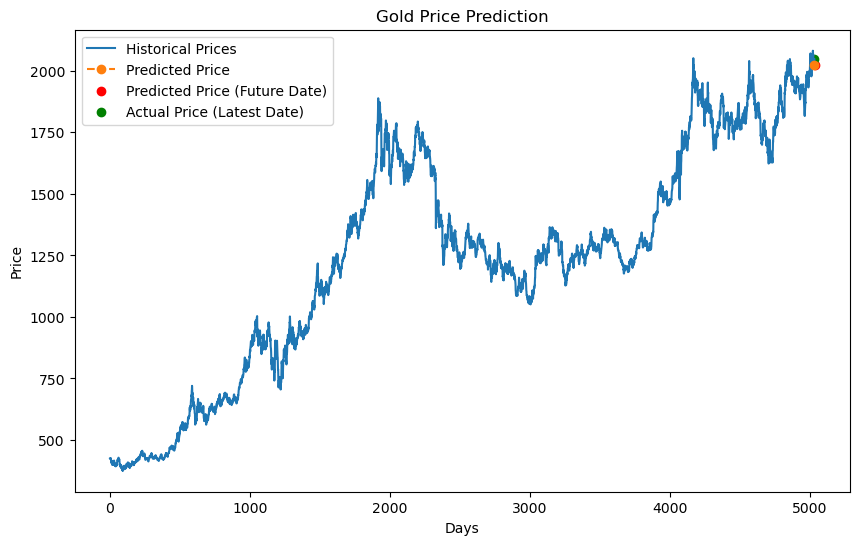

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 下載金價數據
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# 提取收盤價數據
data = goldDF[['Close']].values

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 創建訓練數據
def create_dataset(dataset, look_back=100):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# 創建訓練數據集
X, y = create_dataset(scaled_data)

# 將數據集分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 將數據轉換為 LSTM 適用的格式
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 進行預測
future_date_to_predict = pd.to_datetime(input("\nEnter the future date to predict (YYYY-MM-DD): "))

# 計算需要使用的天數
days_to_look_back = min(100, (future_date_to_predict - goldDF['Date'].min()).days)

# 提取相應的數據
latest_data = data[-days_to_look_back:]
input_data = scaler.transform(latest_data.reshape(-1, 1)).reshape(1, -1, 1)

# 進行預測
predicted_price = model.predict(input_data)
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))

# 輸出預測結果
print(f"\nPredicted price for {future_date_to_predict.strftime('%Y-%m-%d')} is: {predicted_price[0][0]}")



# 提取相應的數據
latest_data = data[-days_to_look_back:]
input_data = scaler.transform(latest_data.reshape(-1, 1)).reshape(1, -1, 1)

# 進行預測
predicted_price = model.predict(input_data)
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))

# 繪製預測圖表
plt.figure(figsize=(10, 6))
plt.plot(data, label='Historical Prices')
plt.plot(range(len(data) - 1, len(data) - 1 + len(predicted_price)), predicted_price, label='Predicted Price', linestyle='dashed', marker='o')
plt.scatter(len(data) - 1 + len(predicted_price), predicted_price, color='red', label='Predicted Price (Future Date)', marker='o')
plt.scatter(len(data) - 1, data[-1], color='green', label='Actual Price (Latest Date)', marker='o')
plt.title(f"Gold Price Prediction")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 下載金價數據
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# 提取收盤價數據
data = goldDF[['Close']].values

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 創建訓練數據
def create_dataset(dataset, look_back=100):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# 創建訓練數據集
X, y = create_dataset(scaled_data)

# 將數據集分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 將數據轉換為 LSTM 適用的格式
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 輸入日期
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# 計算需要使用的天數
days_to_look_back_input = min(365, (input_date - goldDF['Date'].min()).days)

# 提取相應的數據
latest_data_input = data[-days_to_look_back_input:]
input_data_input = scaler.transform(latest_data_input.reshape(-1, 1)).reshape(1, -1, 1)

# 進行預測
predicted_price_input = model.predict(input_data_input)
predicted_price_input = scaler.inverse_transform(predicted_price_input.reshape(-1, 1))

# 輸出預測結果
print(f"\nPredicted price for {input_date.strftime('%Y-%m-%d')} is: {predicted_price_input[0][0]}")

# 繪製額外的圖表
plt.figure(figsize=(15, 10))  # 調整圖表大小

# Plotting historical prices
plt.plot(data, label='Historical Prices')

# Plotting 182-day prediction before input date
predicted_price_before_input = model.predict(X_test[-182:-1])
predicted_price_before_input = scaler.inverse_transform(predicted_price_before_input.reshape(-1, 1))
plt.plot(range(len(data) - 183, len(data) - 1), predicted_price_before_input, label='Predicted Price (Before Input Date)', linestyle='dashed', marker='o')

# Marking the actual price on the input date
plt.scatter(len(data) - 1 - days_to_look_back_input, data[-days_to_look_back_input], color='yellow', label=f'Actual Price (Input Date, {input_date.strftime("%Y-%m-%d")})', marker='o')

# Plotting 182-day prediction after input date
predicted_price_after_input = model.predict(X_test[-1:])
predicted_price_after_input = scaler.inverse_transform(predicted_price_after_input.reshape(-1, 1))
plt.plot(range(len(data) - 1, len(data) + 181), predicted_price_after_input, label='Predicted Price (After Input Date)', linestyle='dashed', marker='o')

# Marking the input date
plt.scatter(len(data) - 1, predicted_price_input[0][0], color='red', label=f'Predicted Price (Input Date, {input_date.strftime("%Y-%m-%d")})', marker='o')

plt.title(f"Gold Price Prediction for Different Time Horizons (Input Date: {input_date.strftime('%Y-%m-%d')})")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
124/124 [==============================] - 6s 37ms/step - loss: 0.0121
Epoch 2/10
124/124 [==============================] - 5s 38ms/step - loss: 3.6934e-04
Epoch 3/10
124/124 [==============================] - 5s 38ms/step - loss: 3.7105e-04
Epoch 4/10
124/124 [==============================] - 5s 37ms/step - loss: 3.5379e-04
Epoch 5/10
124/124 [==============================] - 5s 37ms/step - loss: 3.4020e-04
Epoch 6/10
124/124 [==============================] - 5s 37ms/step - loss: 3.3672e-04
Epoch 7/10
124/124 [==============================] - 5s 38ms/step - loss: 3.2068e-04
Epoch 8/10
124/124 [==============================] - 5s 38ms/step - loss: 2.9066e-04
Epoch 9/10
124/124 [==============================] - 5s 38ms/step - loss: 2.9820e-04
Epoch 10/10
124/124 [==============================] - 5s 38ms/step - loss: 2.8464e-04

Enter the date to visualize (YYYY-MM-DD): 2023-12-21


ValueError: in user code:

    File "/Users/yuinzhi/anaconda3/envs/dscourse/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/yuinzhi/anaconda3/envs/dscourse/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/yuinzhi/anaconda3/envs/dscourse/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/yuinzhi/anaconda3/envs/dscourse/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/yuinzhi/anaconda3/envs/dscourse/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/yuinzhi/anaconda3/envs/dscourse/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 100, 1), found shape=(None, 365, 1)


[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
124/124 [==============================] - 6s 36ms/step - loss: 0.0082
Epoch 2/10
124/124 [==============================] - 5s 38ms/step - loss: 3.9319e-04
Epoch 3/10
124/124 [==============================] - 5s 37ms/step - loss: 3.7625e-04
Epoch 4/10
124/124 [==============================] - 5s 38ms/step - loss: 3.5477e-04
Epoch 5/10
124/124 [==============================] - 5s 38ms/step - loss: 3.5450e-04
Epoch 6/10
124/124 [==============================] - 5s 38ms/step - loss: 3.3672e-04
Epoch 7/10
124/124 [==============================] - 5s 37ms/step - loss: 3.2940e-04
Epoch 8/10
124/124 [==============================] - 5s 39ms/step - loss: 3.0427e-04
Epoch 9/10
124/124 [==============================] - 5s 39ms/step - loss: 2.9469e-04
Epoch 10/10
124/124 [==============================] - 5s 38ms/step - loss: 2.6439e-04

Enter the future date to predict (YYYY-MM-DD): 2023-12-12
1/1 [==========

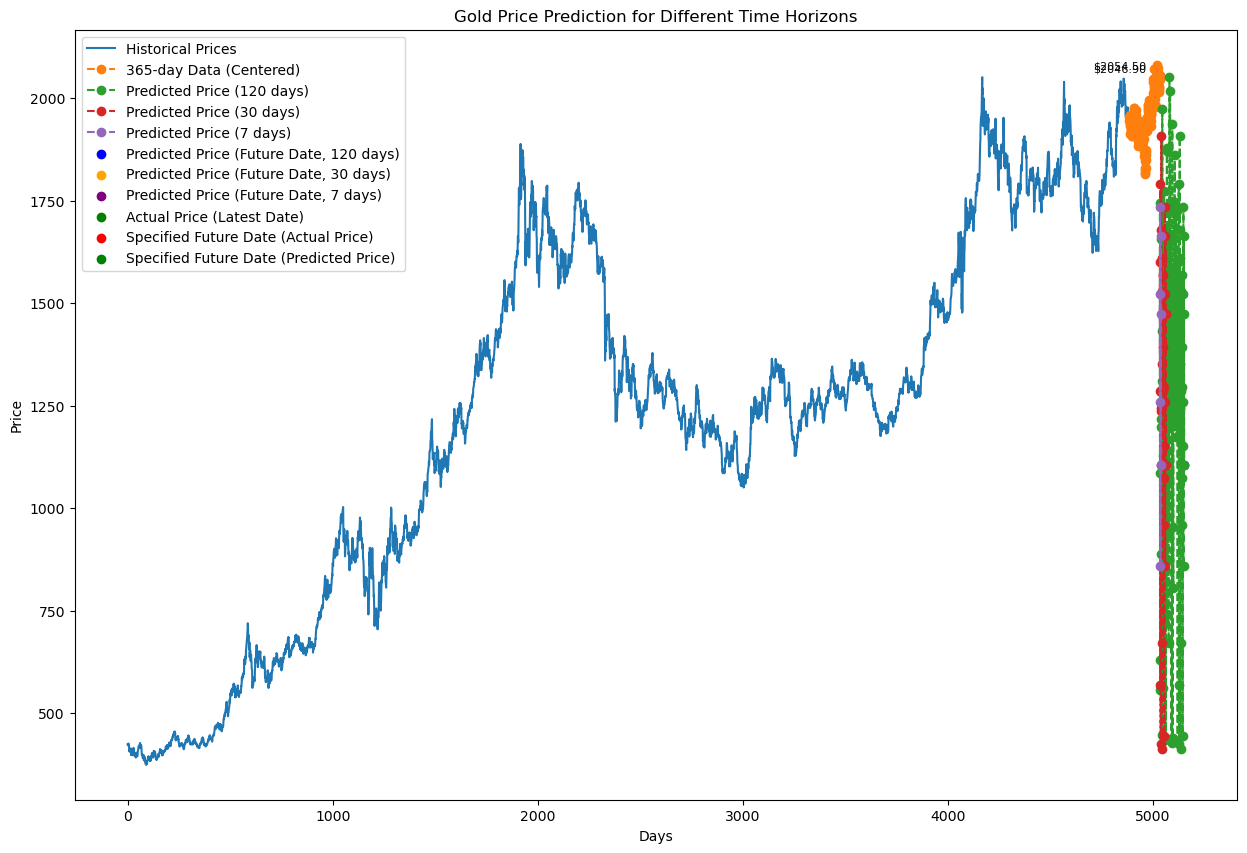

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 下載金價數據
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# 提取收盤價數據
data = goldDF[['Close']].values

# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 創建訓練數據
def create_dataset(dataset, look_back=100):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# 創建訓練數據集
X, y = create_dataset(scaled_data)

# 將數據集分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 將數據轉換為 LSTM 適用的格式
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 進行預測
future_date_to_predict = pd.to_datetime(input("\nEnter the future date to predict (YYYY-MM-DD): "))

# 計算需要使用的天數
days_to_look_back = min(100, (future_date_to_predict - goldDF['Date'].min()).days)

# 提取相應的數據
latest_data = data[-days_to_look_back:]
input_data = scaler.transform(latest_data.reshape(-1, 1)).reshape(1, -1, 1)

# 進行預測
predicted_price = model.predict(input_data)
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))

# 輸出預測結果
print(f"\nPredicted price for {future_date_to_predict.strftime('%Y-%m-%d')} is: {predicted_price[0][0]}")

# 繪製預測圖表
plt.figure(figsize=(15, 10))  # 調整圖表大小

# Plotting historical prices
plt.plot(data, label='Historical Prices')

# Plotting 365-day data centered around the specified date
specified_date = future_date_to_predict
start_date = specified_date - timedelta(days=182)
end_date = specified_date + timedelta(days=182)
start_index = goldDF[goldDF['Date'] >= start_date].index.min()
end_index = goldDF[goldDF['Date'] <= end_date].index.max()
plt.plot(range(start_index, end_index + 1), data[start_index:end_index + 1], label='365-day Data (Centered)', linestyle='dashed', marker='o')

# Plotting 120-day prediction
predicted_price_120 = model.predict(X_test[-120:])
predicted_price_120 = scaler.inverse_transform(predicted_price_120.reshape(-1, 1))
plt.plot(range(len(data) - 1, len(data) - 1 + 120), predicted_price_120, label='Predicted Price (120 days)', linestyle='dashed', marker='o')

# Plotting 30-day prediction
predicted_price_30 = model.predict(X_test[-30:])
predicted_price_30 = scaler.inverse_transform(predicted_price_30.reshape(-1, 1))
plt.plot(range(len(data) - 1, len(data) - 1 + 30), predicted_price_30, label='Predicted Price (30 days)', linestyle='dashed', marker='o')

# Plotting 7-day prediction
predicted_price_7 = model.predict(X_test[-7:])
predicted_price_7 = scaler.inverse_transform(predicted_price_7.reshape(-1, 1))
plt.plot(range(len(data) - 1, len(data) - 1 + 7), predicted_price_7, label='Predicted Price (7 days)', linestyle='dashed', marker='o')

# Marking the future date
plt.scatter(len(data) - 1 + len(predicted_price_120), predicted_price_120[-1], color='blue', label='Predicted Price (Future Date, 120 days)', marker='o')
plt.scatter(len(data) - 1 + len(predicted_price_30), predicted_price_30[-1], color='orange', label='Predicted Price (Future Date, 30 days)', marker='o')
plt.scatter(len(data) - 1 + len(predicted_price_7), predicted_price_7[-1], color='purple', label='Predicted Price (Future Date, 7 days)', marker='o')

# Marking the actual price on the latest date
plt.scatter(len(data) - 1, data[-1], color='green', label='Actual Price (Latest Date)', marker='o')

# Marking the specified future date
plt.scatter(end_index, data[end_index], color='red', label='Specified Future Date (Actual Price)', marker='o')
plt.scatter(end_index, predicted_price[-1], color='green', label='Specified Future Date (Predicted Price)', marker='o')
plt.annotate(f'${data[end_index][0]:.2f}', (end_index, data[end_index][0]),
             textcoords="offset points", xytext=(-10,5), ha='right', fontsize=8)
plt.annotate(f'${predicted_price[-1][0]:.2f}', (end_index, predicted_price[-1][0]),
             textcoords="offset points", xytext=(-10,5), ha='right', fontsize=8)

plt.title(f"Gold Price Prediction for Different Time Horizons")
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Download gold price data
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Extract closing price data
data = goldDF[['Close']].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create training data
def create_dataset(dataset, look_back=100):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Create training dataset
X, y = create_dataset(scaled_data)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict future prices
specified_future_date = pd.to_datetime(input("\nEnter the specified future date (YYYY-MM-DD): "))
days_for_plot = int(input("\nEnter the number of days for the plot: "))

# Calculate the number of days before and after
days_before = days_for_plot // 2
days_after = days_for_plot - days_before

# Extract corresponding data
start_date = specified_future_date - pd.DateOffset(days=days_before)
end_date = specified_future_date + pd.DateOffset(days=days_after)

subset_data = goldDF[(goldDF['Date'] >= start_date) & (goldDF['Date'] <= end_date)]
subset_data.reset_index(drop=True, inplace=True)

# Extract corresponding scaled data
subset_scaled_data = scaler.transform(subset_data[['Close']].values).reshape(-1, 1)

# Prepare input data for prediction
input_data = np.reshape(subset_scaled_data, (1, subset_scaled_data.shape[0], 1))

# Predict prices
predicted_price = model.predict(input_data)
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))

# Plot historical and predicted prices
plt.figure(figsize=(15, 5))
plt.plot(subset_data['Date'], subset_data['Close'], label='Historical Prices')
plt.plot(subset_data['Date'].iloc[-1], predicted_price[-1], label=f'Predicted Price', linestyle='dashed', marker='o', color='blue')

# Mark the specified future date
plt.scatter(specified_future_date, subset_data['Close'].iloc[-1], color='green', label='Actual Price (Latest Date)', marker='o')

# Annotation
plt.annotate(f'Specified Future Date: {specified_future_date.strftime("%Y-%m-%d")}',
             (specified_future_date, subset_data['Close'].iloc[-1]),
             textcoords="offset points", xytext=(-10, 5), ha='right', fontsize=8)

plt.title(f"Gold Price Prediction - {days_for_plot} Days Around Specified Future Date")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display the plot
plt.show()


[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
124/124 [==============================] - 6s 37ms/step - loss: 0.0117
Epoch 2/10
124/124 [==============================] - 5s 38ms/step - loss: 3.5282e-04
Epoch 3/10
124/124 [==============================] - 5s 38ms/step - loss: 3.4327e-04
Epoch 4/10
124/124 [==============================] - 5s 38ms/step - loss: 3.3734e-04
Epoch 5/10
124/124 [==============================] - 5s 38ms/step - loss: 3.2294e-04
Epoch 6/10
124/124 [==============================] - 5s 38ms/step - loss: 3.1063e-04
Epoch 7/10
124/124 [==============================] - 5s 38ms/step - loss: 3.0547e-04
Epoch 8/10
124/124 [==============================] - 5s 38ms/step - loss: 2.9210e-04
Epoch 9/10
124/124 [==============================] - 5s 38ms/step - loss: 2.6573e-04
Epoch 10/10
124/124 [==============================] - 5s 38ms/step - loss: 2.4251e-04

Enter the specified future date (YYYY-MM-DD): 23023-12-23


DateParseError: year 23023 is out of range: 23023-12-23, at position 0

[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-12


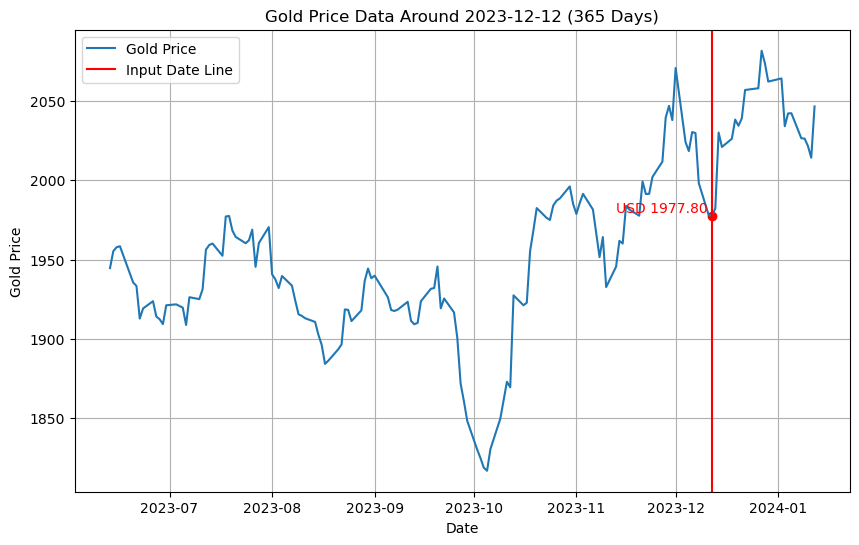

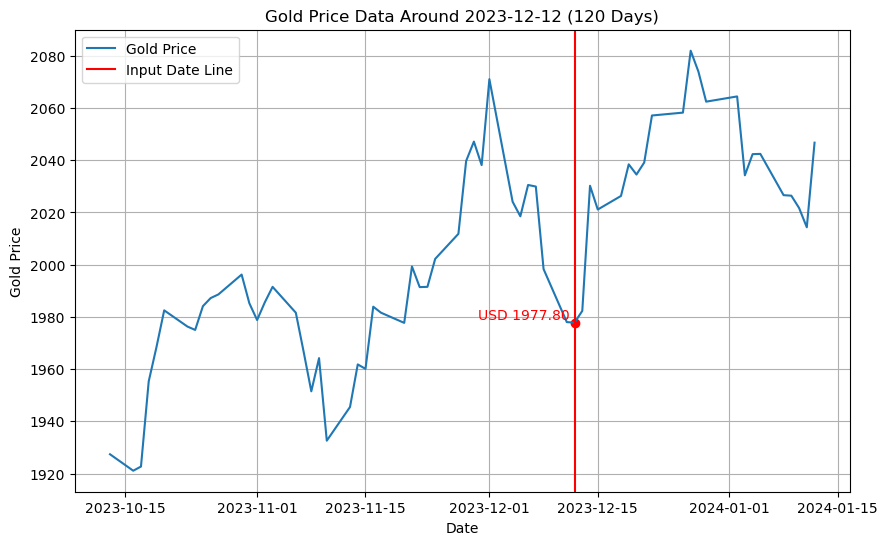

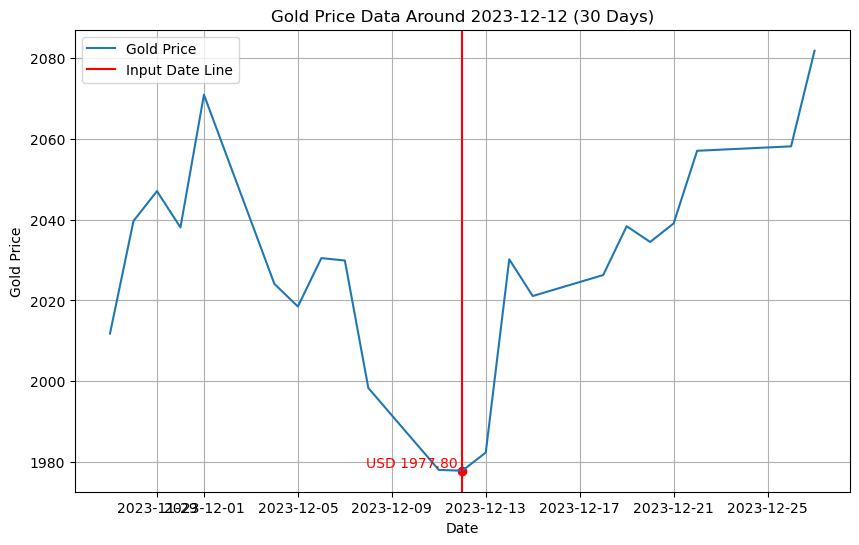

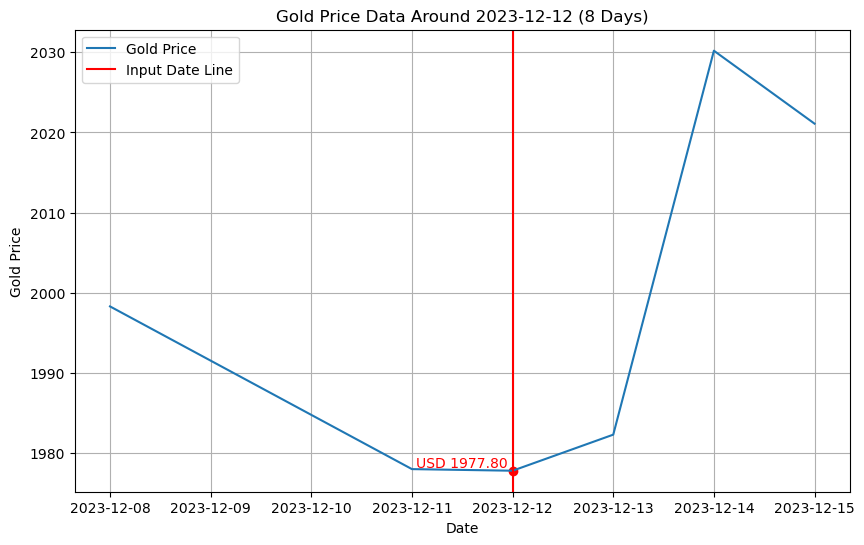

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 下載金價數據
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# 輸入日期
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# 定义不同时间范围的前后天数
days_ranges = [365, 120, 30, 8]

# 绘制多个图表
for days in days_ranges:
    days_before = days_after = days // 2

    # 筛选数据
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    # 绘制图表
    plt.figure(figsize=(10, 6))
    plt.plot(selected_data['Date'], selected_data['Close'], label='Gold Price')
    
    # 标记输入日期的金价数据点
    input_date_data = selected_data[selected_data['Date'] == input_date]
    input_date_price = input_date_data['Close'].values[0]
    plt.scatter(input_date_data['Date'], input_date_price, color='red')
    
    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')
    
    # 在图表上显示输入日期的金价数值
    plt.text(input_date, input_date_price, f'USD {input_date_price:.2f} ', ha='right', va='bottom', color='red')
    
    plt.title(f'Gold Price Data Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-11-14
Epoch 1/10
2/2 [==============================] - 1s 25ms/step - loss: 0.5854
Epoch 2/10
2/2 [==============================] - 0s 18ms/step - loss: 0.4172
Epoch 3/10
2/2 [==============================] - 0s 20ms/step - loss: 0.2832
Epoch 4/10
2/2 [==============================] - 0s 17ms/step - loss: 0.1731
Epoch 5/10
2/2 [==============================] - 0s 20ms/step - loss: 0.1062
Epoch 6/10
2/2 [==============================] - 0s 20ms/step - loss: 0.1247
Epoch 7/10
2/2 [==============================] - 0s 17ms/step - loss: 0.1379
Epoch 8/10
2/2 [==============================] - 0s 23ms/step - loss: 0.1075
Epoch 9/10
2/2 [==============================] - 0s 18ms/step - loss: 0.0899
Epoch 10/10
2/2 [==============================] - 0s 19ms/step - loss: 0.0875
X_test is empty, unable to make predictions.


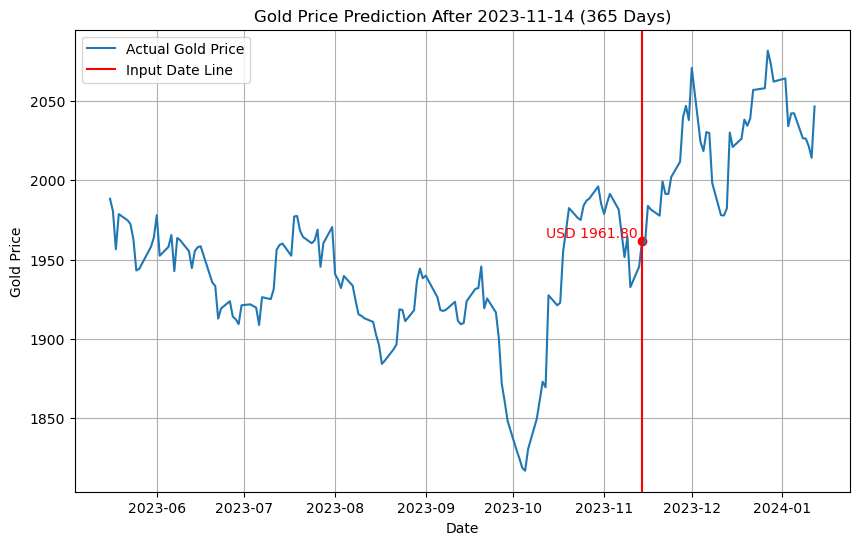

Epoch 1/10
2/2 [==============================] - 1s 25ms/step - loss: 0.4046
Epoch 2/10
2/2 [==============================] - 0s 22ms/step - loss: 0.2554
Epoch 3/10
2/2 [==============================] - 0s 22ms/step - loss: 0.1509
Epoch 4/10
2/2 [==============================] - 0s 20ms/step - loss: 0.1001
Epoch 5/10
2/2 [==============================] - 0s 21ms/step - loss: 0.1043
Epoch 6/10
2/2 [==============================] - 0s 17ms/step - loss: 0.0998
Epoch 7/10
2/2 [==============================] - 0s 19ms/step - loss: 0.0842
Epoch 8/10
2/2 [==============================] - 0s 20ms/step - loss: 0.0785
Epoch 9/10
2/2 [==============================] - 0s 17ms/step - loss: 0.0770
Epoch 10/10
2/2 [==============================] - 0s 19ms/step - loss: 0.0759
X_test is empty, unable to make predictions.


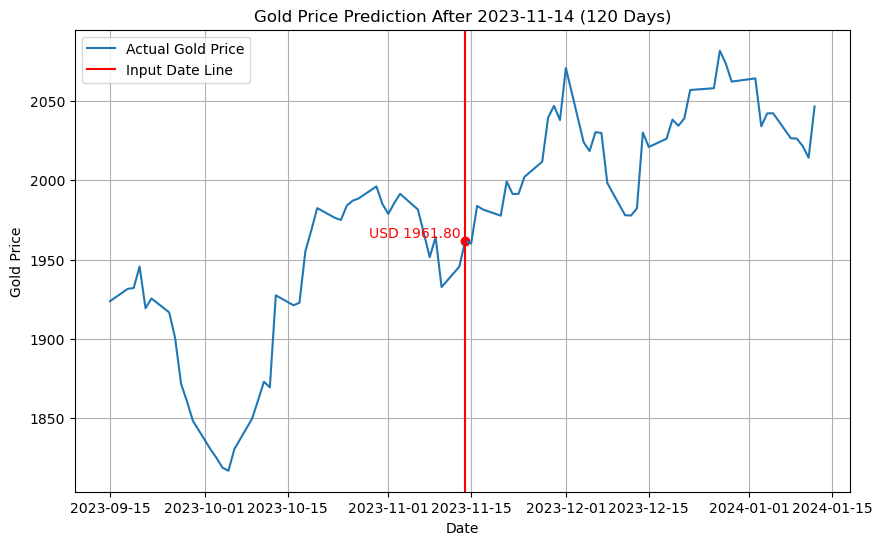

Epoch 1/10
2/2 [==============================] - 1s 24ms/step - loss: 0.4686
Epoch 2/10
2/2 [==============================] - 0s 17ms/step - loss: 0.3316
Epoch 3/10
2/2 [==============================] - 0s 18ms/step - loss: 0.2170
Epoch 4/10
2/2 [==============================] - 0s 18ms/step - loss: 0.1258
Epoch 5/10
2/2 [==============================] - 0s 17ms/step - loss: 0.1044
Epoch 6/10
2/2 [==============================] - 0s 20ms/step - loss: 0.1345
Epoch 7/10
2/2 [==============================] - 0s 17ms/step - loss: 0.1139
Epoch 8/10
2/2 [==============================] - 0s 19ms/step - loss: 0.0938
Epoch 9/10
2/2 [==============================] - 0s 17ms/step - loss: 0.0878
Epoch 10/10
2/2 [==============================] - 0s 22ms/step - loss: 0.0888
X_test is empty, unable to make predictions.


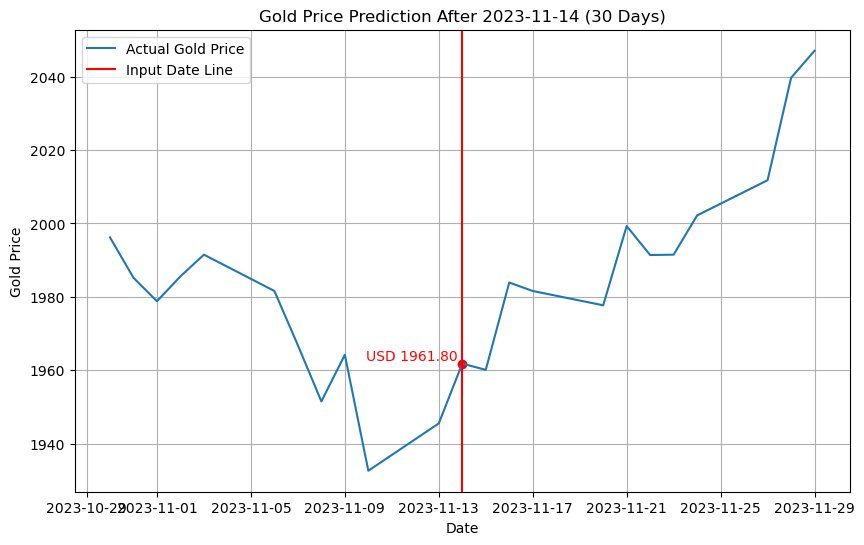

Epoch 1/10
2/2 [==============================] - 1s 24ms/step - loss: 0.3991
Epoch 2/10
2/2 [==============================] - 0s 17ms/step - loss: 0.2579
Epoch 3/10
2/2 [==============================] - 0s 19ms/step - loss: 0.1501
Epoch 4/10
2/2 [==============================] - 0s 18ms/step - loss: 0.1078
Epoch 5/10
2/2 [==============================] - 0s 19ms/step - loss: 0.1247
Epoch 6/10
2/2 [==============================] - 0s 21ms/step - loss: 0.1087
Epoch 7/10
2/2 [==============================] - 0s 20ms/step - loss: 0.0920
Epoch 8/10
2/2 [==============================] - 0s 19ms/step - loss: 0.0916
Epoch 9/10
2/2 [==============================] - 0s 21ms/step - loss: 0.0956
Epoch 10/10
2/2 [==============================] - 0s 21ms/step - loss: 0.0976
X_test is empty, unable to make predictions.


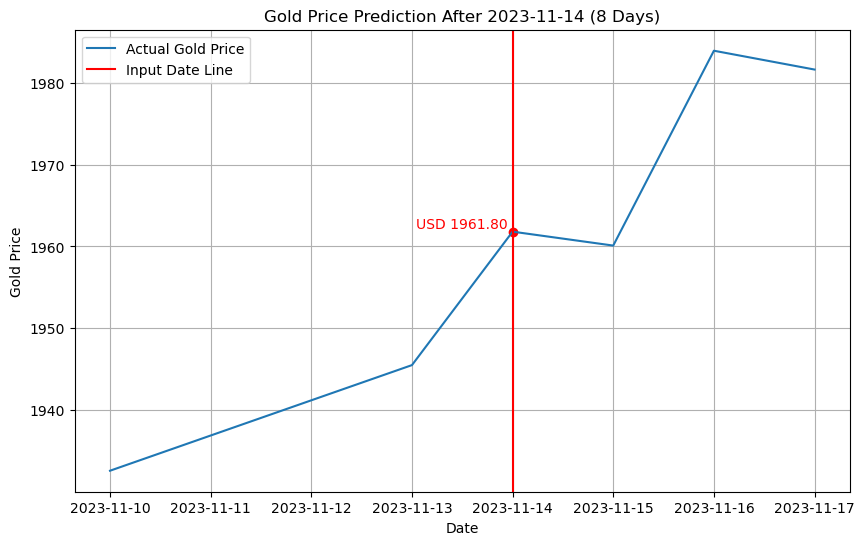

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 下載金價數據
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# 輸入日期
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# 定义不同时间范围的前后天数
days_ranges = [365, 120, 30, 8]

# 绘制多个图表和进行 LSTM 训练与预测
for days in days_ranges:
    days_before = days_after = days // 2

    # 筛选数据
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    # 提取训练数据
    train_data = goldDF[goldDF['Date'] <= input_date].tail(100)

    # 特征缩放
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))

    # 创建训练集
    X, y = [], []
    for i in range(60, len(train_data)):
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # 创建LSTM模型
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 训练模型
    model.fit(X, y, epochs=10, batch_size=32)

    # 使用最新的100天进行预测
    latest_data = goldDF[goldDF['Date'] > input_date].head(100)
    scaled_latest_data = scaler.transform(latest_data['Close'].values.reshape(-1, 1))

    X_test = []
    for i in range(60, len(latest_data)):
        X_test.append(scaled_latest_data[i-60:i, 0])
    X_test = np.array(X_test)

    # 预测未来价格
    if X_test.shape[0] > 0:
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)
        print("Predictions shape:", predictions.shape)
    else:
        print("X_test is empty, unable to make predictions.")

    # 绘制图表
    plt.figure(figsize=(10, 6))
    plt.plot(selected_data['Date'], selected_data['Close'], label='Actual Gold Price')
    
    # 标记输入日期的金价数据点
    input_date_data = selected_data[selected_data['Date'] == input_date]
    input_date_price = input_date_data['Close'].values[0]
    plt.scatter(input_date_data['Date'], input_date_price, color='red')
    
    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')
    
    # 在图表上显示输入日期的金价数值
    plt.text(input_date, input_date_price, f'USD {input_date_price:.2f} ', ha='right', va='bottom', color='red')

    # 绘制预测的金价
    if X_test.shape[0] > 0:
        predicted_dates = latest_data['Date'].iloc[60:60+predictions.shape[0]]
        plt.plot(predicted_dates, predictions, label='Predicted Gold Price', linestyle='--', color='blue')

    plt.title(f'Gold Price Prediction After {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-12


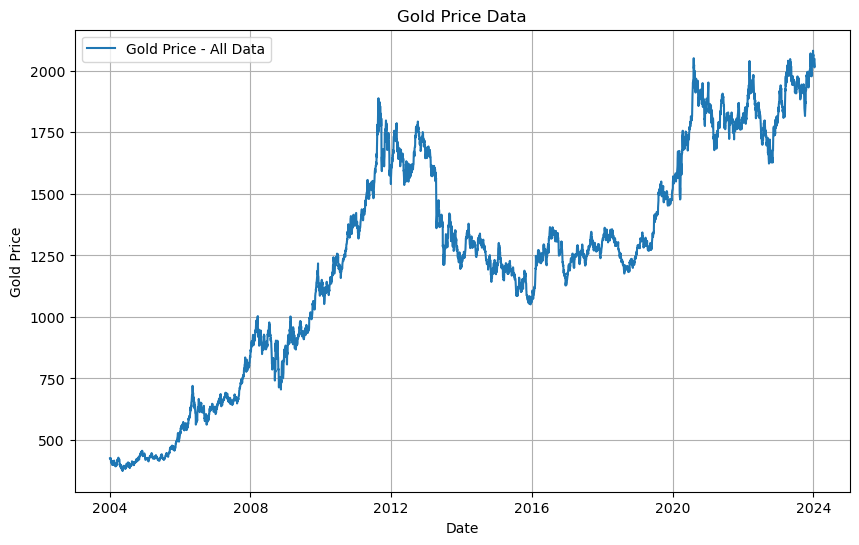

Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.3610
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.3190
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2803
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2432
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2082
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1765
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1464
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1194
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0954
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0572
Epoch 12/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 13/50
7/7 [==============================] - 0s 1ms/step - loss: 0.

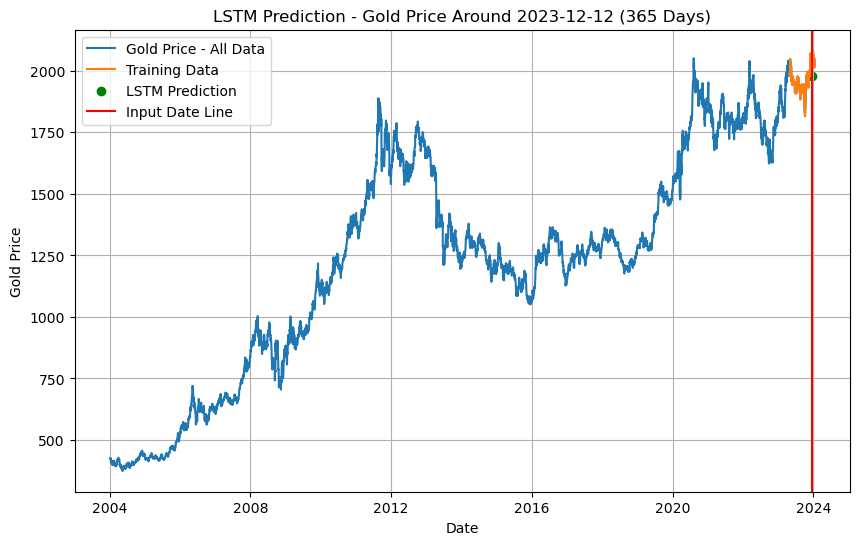

Epoch 1/50
3/3 [==============================] - 1s 2ms/step - loss: 0.4967
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4768
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4567
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4386
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4202
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4027
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3859
Epoch 8/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3684
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3530
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3368
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3215
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3058
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.

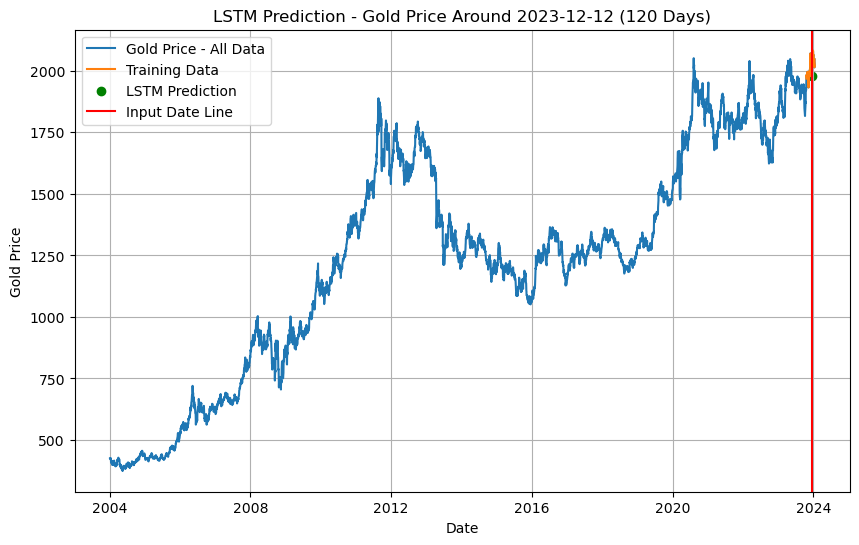

Epoch 1/50
1/1 [==============================] - 1s 657ms/step - loss: 0.3062
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3009
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2958
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2906
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2855
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2804
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2754
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2705
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2656
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2607
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2559
Epoch 12/50
1/1 [==============================] - 0s 4ms/step - loss: 0.2511
Epoch 13/50
1/1 [==============================] - 0s 3ms/step - loss: 

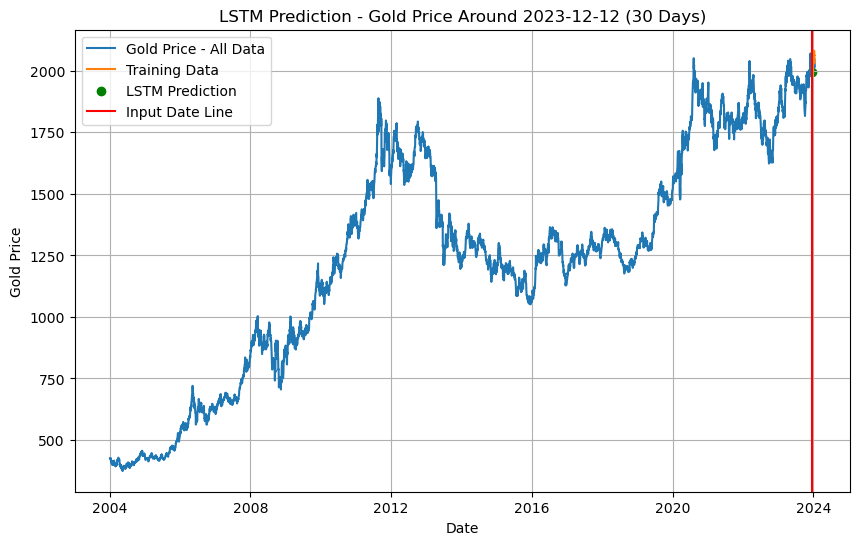

Epoch 1/50
1/1 [==============================] - 1s 675ms/step - loss: 0.2394
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2367
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2340
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2314
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2288
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2263
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2238
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2214
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2190
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2166
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2143
Epoch 12/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2120
Epoch 13/50
1/1 [==============================] - 0s 3ms/step - loss: 

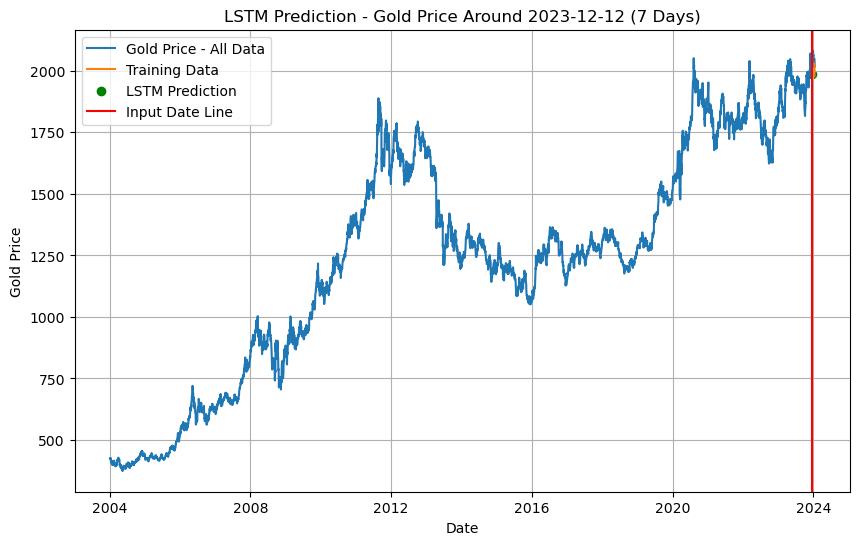

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Download gold price data
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Input date
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# Define different time ranges for visualization
days_ranges = [365, 120, 30, 7]

# Plot all data
plt.figure(figsize=(10, 6))
plt.plot(goldDF['Date'], goldDF['Close'], label='Gold Price - All Data')
plt.title('Gold Price Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data for LSTM
def prepare_lstm_data(data, input_date, days_before):
    input_date_index = data[data['Date'] == input_date].index[0]
    start_index = max(0, input_date_index - days_before)
    end_index = input_date_index + days_before

    lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    lstm_data_scaled = scaler.fit_transform(lstm_data)

    return lstm_data_scaled, scaler

# Train and predict with LSTM for each days_range
for days in days_ranges:
    days_before = days_after = days // 2

    # Prepare data for LSTM
    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, days_before)

    # Split data into training and testing sets
    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # Create LSTM model
    model = create_lstm_model(input_shape=1)

    # Train the model
    model.fit(X, y, epochs=50, batch_size=32)

    # Predict using the last 100 days of data
    input_sequence = lstm_data[-days_before:]
    input_sequence = np.reshape(input_sequence, (1, len(input_sequence), 1))

    # Remove the padding
    predicted_price_scaled = model.predict(input_sequence[:, :1, :])
    predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]

    # Plot LSTM prediction
    plt.figure(figsize=(10, 6))
    plt.plot(goldDF['Date'], goldDF['Close'], label='Gold Price - All Data')
    plt.plot(goldDF['Date'].iloc[-days_before:], scaler.inverse_transform(lstm_data)[-days_before:], label='Training Data')
    plt.scatter(input_date, predicted_price, color='green', label='LSTM Prediction')
    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')
    plt.title(f'LSTM Prediction - Gold Price Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-22


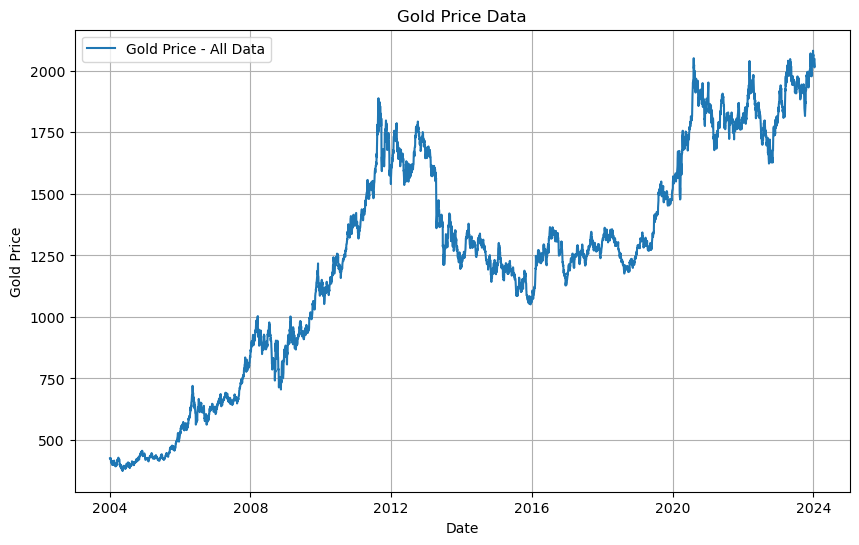

Epoch 1/50
4/4 [==============================] - 1s 2ms/step - loss: 0.3400
Epoch 2/50
4/4 [==============================] - 0s 2ms/step - loss: 0.3171
Epoch 3/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2949
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2740
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2536
Epoch 6/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2338
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2154
Epoch 8/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1977
Epoch 9/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1801
Epoch 10/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1636
Epoch 11/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1474
Epoch 12/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1327
Epoch 13/50
4/4 [==============================] - 0s 1ms/step - loss: 0.

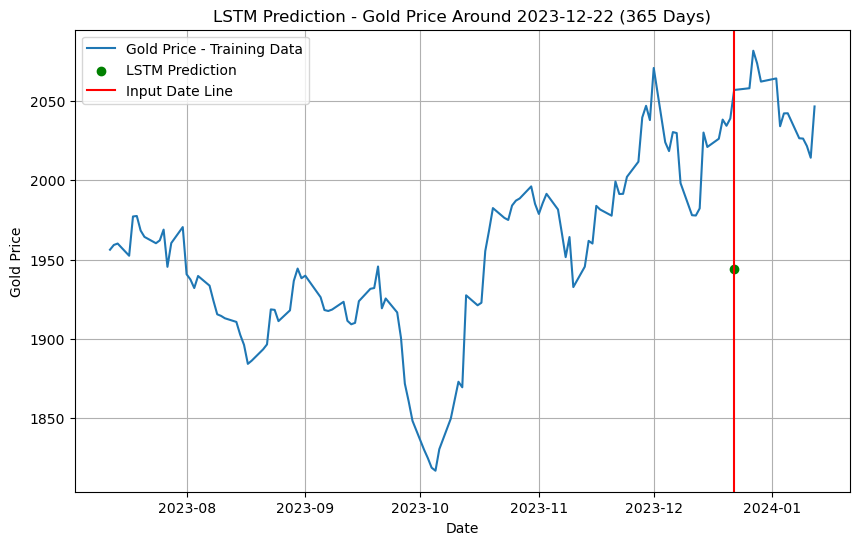

Epoch 1/50
4/4 [==============================] - 1s 2ms/step - loss: 0.3767
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.3523
Epoch 3/50
4/4 [==============================] - 0s 1ms/step - loss: 0.3287
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.3062
Epoch 5/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2851
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2644
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2438
Epoch 8/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2251
Epoch 9/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2070
Epoch 10/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1886
Epoch 11/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1717
Epoch 12/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1554
Epoch 13/50
4/4 [==============================] - 0s 1ms/step - loss: 0.

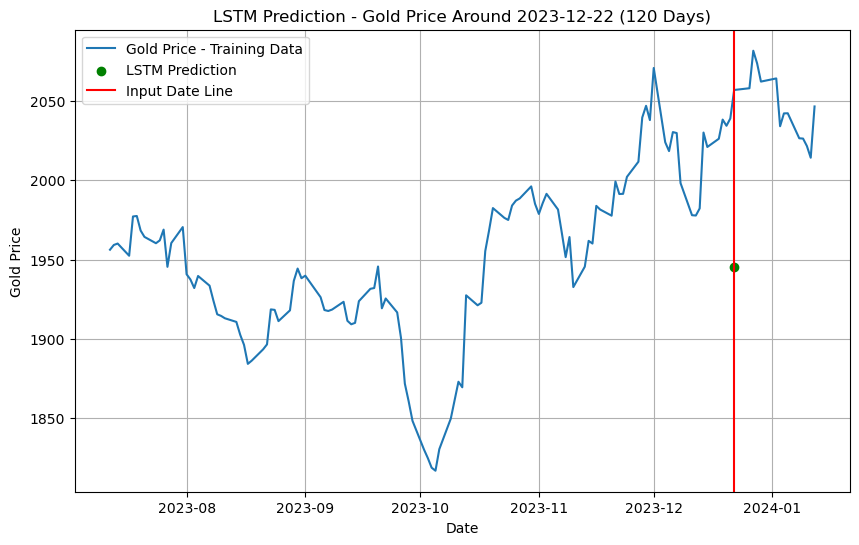

Epoch 1/50
4/4 [==============================] - 2s 2ms/step - loss: 0.3332
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.3102
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2878
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2663
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2457
Epoch 6/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2261
Epoch 7/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2077
Epoch 8/50
4/4 [==============================] - 0s 2ms/step - loss: 0.1894
Epoch 9/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1727
Epoch 10/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1557
Epoch 11/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1405
Epoch 12/50
4/4 [==============================] - 0s 2ms/step - loss: 0.1256
Epoch 13/50
4/4 [==============================] - 0s 2ms/step - loss: 0.

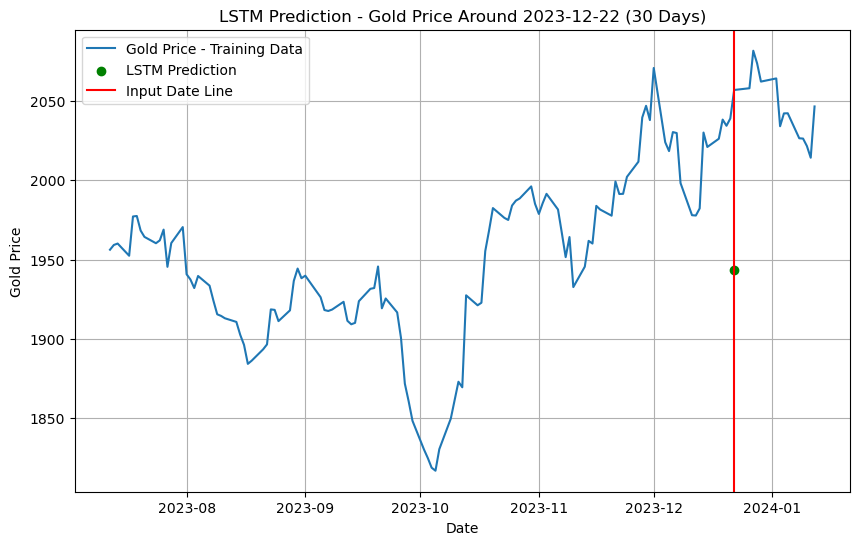

Epoch 1/50
4/4 [==============================] - 1s 1ms/step - loss: 0.3048
Epoch 2/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2845
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2646
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2461
Epoch 5/50
4/4 [==============================] - 0s 1ms/step - loss: 0.2271
Epoch 6/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2093
Epoch 7/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1923
Epoch 8/50
4/4 [==============================] - 0s 2ms/step - loss: 0.1749
Epoch 9/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1592
Epoch 10/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1433
Epoch 11/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1290
Epoch 12/50
4/4 [==============================] - 0s 1ms/step - loss: 0.1141
Epoch 13/50
4/4 [==============================] - 0s 1ms/step - loss: 0.

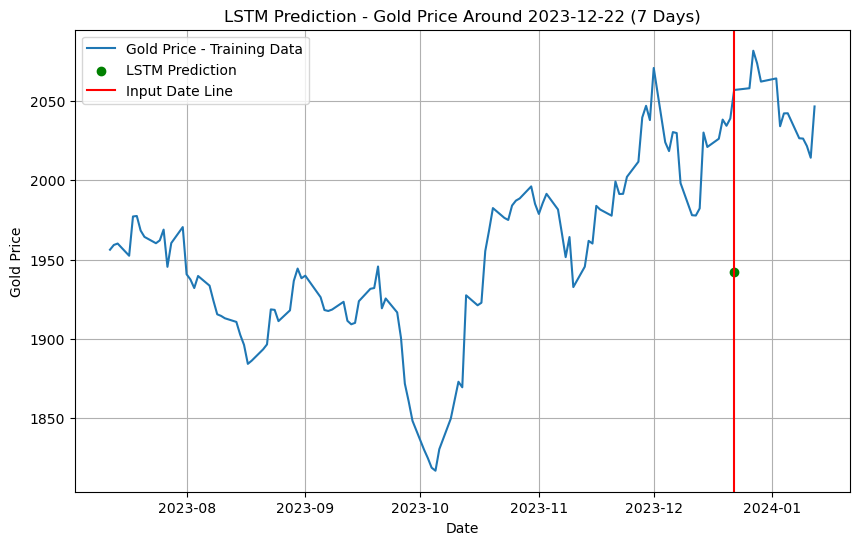

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Download gold price data
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Input date
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# Define different time ranges for visualization
days_ranges = [365, 120, 30, 7]

# Plot all data
plt.figure(figsize=(10, 6))
plt.plot(goldDF['Date'], goldDF['Close'], label='Gold Price - All Data')
plt.title('Gold Price Data')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data for LSTM
def prepare_lstm_data(data, input_date, days_before, days_after):
    input_date_index = data[data['Date'] == input_date].index[0]
    start_index = max(0, input_date_index - days_before)
    end_index = input_date_index + days_after

    lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    lstm_data_scaled = scaler.fit_transform(lstm_data)

    return lstm_data_scaled, scaler

# Train and predict with LSTM for each days_range
for days in days_ranges:
    days_before = days_after = days // 2

    # Specify the number of days for training and prediction
    train_days = 100
    predict_days = 30

    # Prepare data for LSTM
    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, train_days, predict_days)

    # Split data into training and testing sets
    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # Create LSTM model
    model = create_lstm_model(input_shape=1)

    # Train the model
    model.fit(X, y, epochs=50, batch_size=32)

    # Predict using the specified days for training and prediction
    input_sequence = lstm_data[-train_days:]
    input_sequence = np.reshape(input_sequence, (1, len(input_sequence), 1))

    # Remove the padding
    predicted_price_scaled = model.predict(input_sequence[:, :1, :])
    predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]

    # Plot LSTM prediction
    plt.figure(figsize=(10, 6))
    plt.plot(goldDF['Date'].iloc[-train_days-predict_days:], goldDF['Close'].iloc[-train_days-predict_days:], label='Gold Price - Training Data')
    plt.scatter(input_date, predicted_price, color='green', label='LSTM Prediction')
    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')
    plt.title(f'LSTM Prediction - Gold Price Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-18
Epoch 1/50
7/7 [==============================] - 1s 2ms/step - loss: 0.3418
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2963
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2554
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2178
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1841
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1530
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1253
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1002
Epoch 9/50
7/7 [==============================] - 0s 2ms/step - loss: 0.0789
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0601
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0459
Epoch 12/50
7/7 [===========

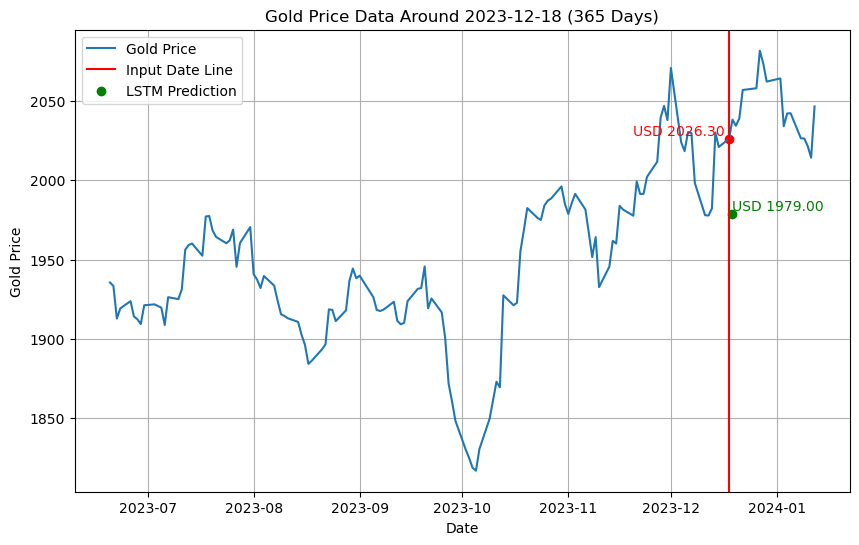

Epoch 1/50
3/3 [==============================] - 1s 2ms/step - loss: 0.4505
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4294
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4104
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3901
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3718
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3534
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3355
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3182
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3012
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2850
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2689
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2535
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.

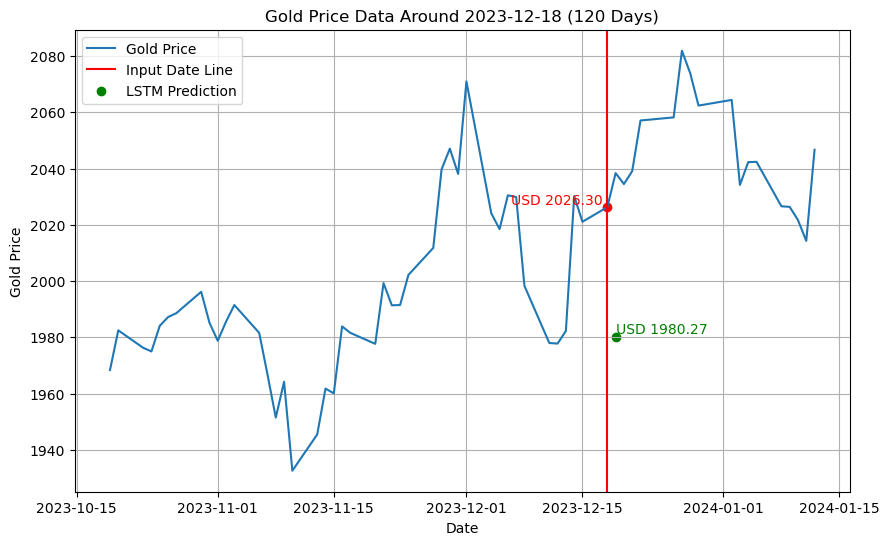

Epoch 1/50
1/1 [==============================] - 1s 727ms/step - loss: 0.3847
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3792
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3736
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3682
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3628
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3574
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3521
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3468
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3416
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3364
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3313
Epoch 12/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3262
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

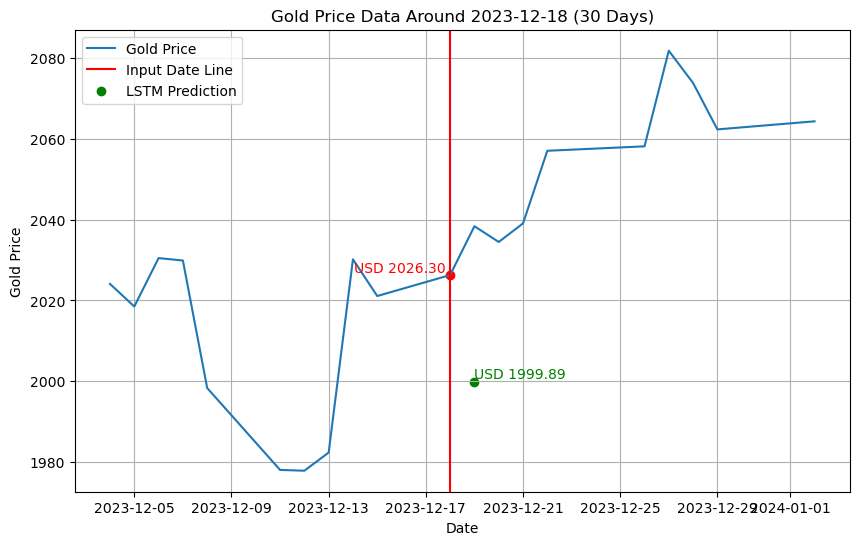

Epoch 1/50
1/1 [==============================] - 1s 729ms/step - loss: 0.6644
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 0.6569
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 0.6495
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.6421
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.6347
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.6274
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.6201
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.6128
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.6055
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 0.5983
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 0.5912
Epoch 12/50
1/1 [==============================] - 0s 3ms/step - loss: 0.5840
Epoch 13/50
1/1 [==============================] - 0s 3ms/step - loss: 

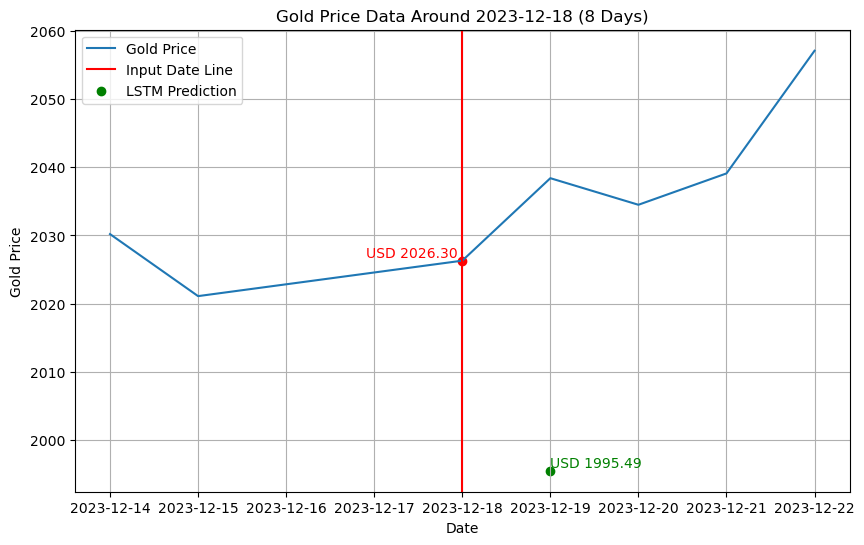

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Download gold price data
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Input date
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# Define different time ranges for visualization
days_ranges = [365, 120, 30, 8]

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to prepare data for LSTM
def prepare_lstm_data(data, input_date, days_before, days_after):
    input_date_index = data[data['Date'] == input_date].index[0]
    start_index = max(0, input_date_index - days_before)
    end_index = input_date_index + days_after

    lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    lstm_data_scaled = scaler.fit_transform(lstm_data)

    return lstm_data_scaled, scaler

# Function to train LSTM model
def train_lstm_model(model, X, y, epochs=50, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size)

# Plot multiple charts
for days in days_ranges:
    days_before = days_after = days // 2

    # Filter data
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    # Prepare data for LSTM
    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, days_before, days_after)

    # Split data into training and testing sets
    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # Create LSTM model
    model = create_lstm_model(input_shape=1)

    # Train the model
    train_lstm_model(model, X, y)

    # Predict using LSTM
    input_sequence = lstm_data[-days_before:]
    input_sequence = np.reshape(input_sequence, (1, len(input_sequence), 1))
    predicted_price_scaled = model.predict(input_sequence[:, :1, :])
    predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]

    # Plot chart
    plt.figure(figsize=(10, 6))
    plt.plot(selected_data['Date'], selected_data['Close'], label='Gold Price')

    # Mark input date's gold price data point
    input_date_data = selected_data[selected_data['Date'] == input_date]
    input_date_price = input_date_data['Close'].values[0]
    plt.scatter(input_date_data['Date'], input_date_price, color='red')

    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')

    # Show input date's gold price value on the chart
    plt.text(input_date, input_date_price, f'USD {input_date_price:.2f} ', ha='right', va='bottom', color='red')

    # Plot the LSTM prediction
    plt.scatter(input_date + pd.DateOffset(days=1), predicted_price, color='green', label='LSTM Prediction')
    plt.text(input_date + pd.DateOffset(days=1), predicted_price, f'USD {predicted_price:.2f} ', ha='left', va='bottom', color='green')

    plt.title(f'Gold Price Data Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-14
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.3269
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2896
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2547
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2216
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1902
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1609
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1337
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1079
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0854
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0658
Epoch 11/50
7/7 [==============================] - 0s 2ms/step - loss: 0.0492
Epoch 12/50
7/7 [===========

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


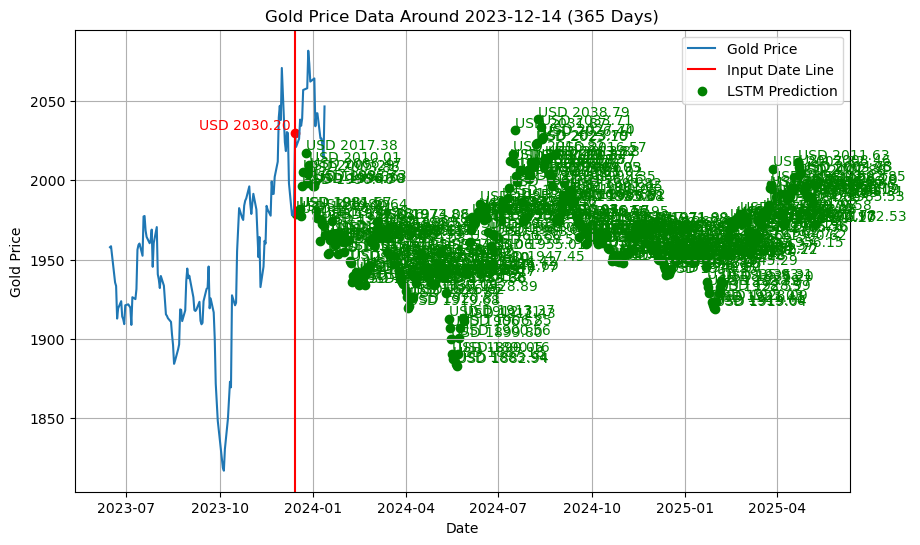

Epoch 1/50
3/3 [==============================] - 1s 2ms/step - loss: 0.4440
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4238
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.4044
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3853
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3671
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3487
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3313
Epoch 8/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3147
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2977
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2814
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2655
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2501
Epoch 13/50
3/3 [==============================] - 0s 1ms/step - loss: 0.

1/1 [==============================] - 0s 10ms/step


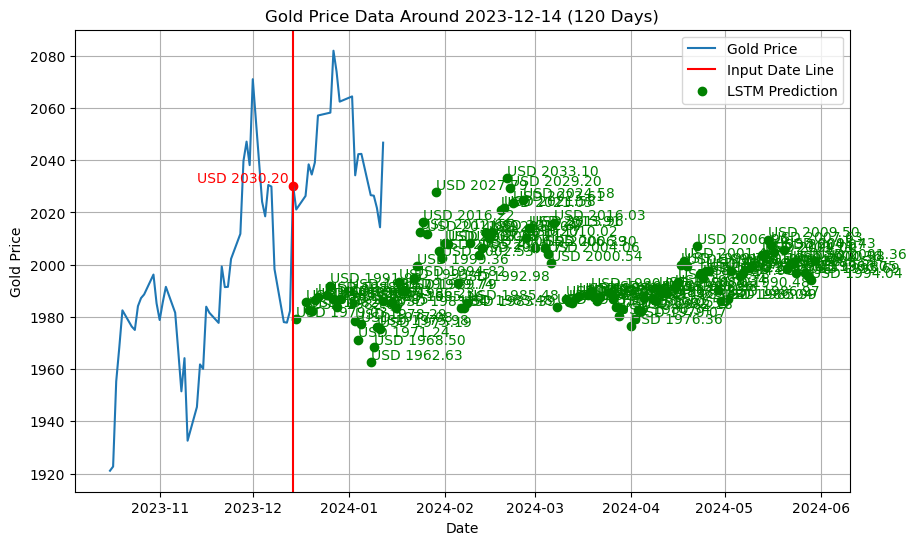

Epoch 1/50
1/1 [==============================] - 1s 744ms/step - loss: 0.3377
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3323
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3268
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3215
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3161
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3108
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3056
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3004
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2953
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2902
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2851
Epoch 12/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2801
Epoch 13/50
1/1 [==============================] - 0s 3ms/step - loss: 

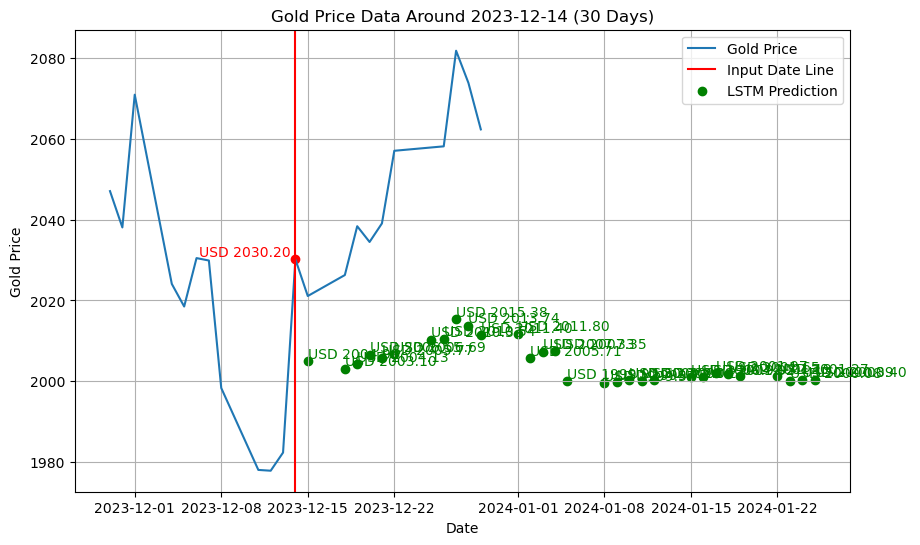

Epoch 1/50
1/1 [==============================] - 1s 699ms/step - loss: 0.4088
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.4039
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3990
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3941
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3893
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3845
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3798
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3751
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3705
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3659
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3613
Epoch 12/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3568
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

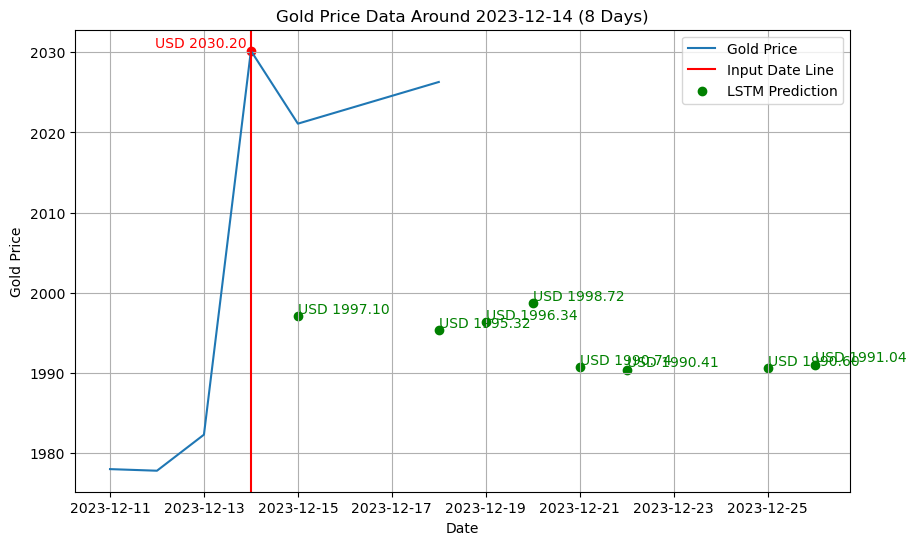

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Download gold price data
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Input date
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# Define different time ranges for visualization
days_ranges = [365, 120, 30, 8]

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to prepare data for LSTM
def prepare_lstm_data(data, input_date, days_before, days_after):
    input_date_index = data[data['Date'] == input_date].index
    if not input_date_index.empty:
        input_date_index = input_date_index[0]
        start_index = max(0, input_date_index - days_before)
        end_index = input_date_index + days_after

        lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        lstm_data_scaled = scaler.fit_transform(lstm_data)

        return lstm_data_scaled, scaler
    else:
        print(f"Input date {input_date} not found in the dataset.")
        return None, None

# Function to train LSTM model
def train_lstm_model(model, X, y, epochs=50, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size)

# Plot multiple charts
for days in days_ranges:
    days_before = days_after = days // 2

    # Filter data
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    # Prepare data for LSTM
    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, days_before, days_after)

    # Check if data is available for input date
    if lstm_data is None:
        continue

    # Split data into training and testing sets
    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # Create LSTM model
    model = create_lstm_model(input_shape=1)

    # Train the model
    train_lstm_model(model, X, y)

    # Predict using LSTM for each day in the range
    predictions = []
    for day in range(days):
        input_sequence = lstm_data[-days_before:]
        input_sequence = np.reshape(input_sequence, (1, len(input_sequence), 1))
        predicted_price_scaled = model.predict(input_sequence[:, :1, :])
        predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]
        predictions.append(predicted_price)

        # Update input sequence for the next prediction
        lstm_data = np.append(lstm_data, [[predicted_price_scaled[0, 0]]], axis=0)

    # Plot chart
    plt.figure(figsize=(10, 6))
    plt.plot(selected_data['Date'], selected_data['Close'], label='Gold Price')

    # Mark input date's gold price data point
    input_date_data = selected_data[selected_data['Date'] == input_date]
    input_date_price = input_date_data['Close'].values[0]
    plt.scatter(input_date_data['Date'], input_date_price, color='red')

    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')

    # Show input date's gold price value on the chart
    plt.text(input_date, input_date_price, f'USD {input_date_price:.2f} ', ha='right', va='bottom', color='red')

    # Plot the LSTM predictions
    predicted_dates = pd.date_range(start=input_date + pd.DateOffset(days=1), periods=days, freq='B')
    plt.scatter(predicted_dates, predictions, color='green', label='LSTM Prediction')
    for date, pred in zip(predicted_dates, predictions):
        plt.text(date, pred, f'USD {pred:.2f} ', ha='left', va='bottom', color='green')

    plt.title(f'Gold Price Data Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-12
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.3285
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2873
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2494
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2140
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1814
Epoch 6/50
7/7 [==============================] - 0s 2ms/step - loss: 0.1513
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1241
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0999
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0785
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0604
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0455
Epoch 12/50
7/7 [===========

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


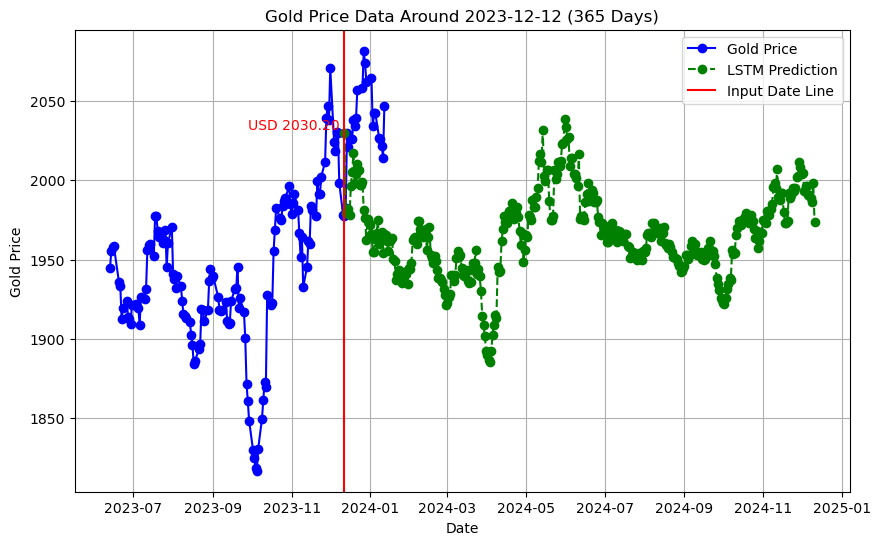

Epoch 1/50
3/3 [==============================] - 1s 2ms/step - loss: 0.4168
Epoch 2/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3962
Epoch 3/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3757
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3557
Epoch 5/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3360
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3176
Epoch 7/50
3/3 [==============================] - 0s 1ms/step - loss: 0.2992
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2817
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2645
Epoch 10/50
3/3 [==============================] - 0s 1ms/step - loss: 0.2474
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2306
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2154
Epoch 13/50
3/3 [==============================] - 0s 1ms/step - loss: 0.

1/1 [==============================] - 0s 9ms/step


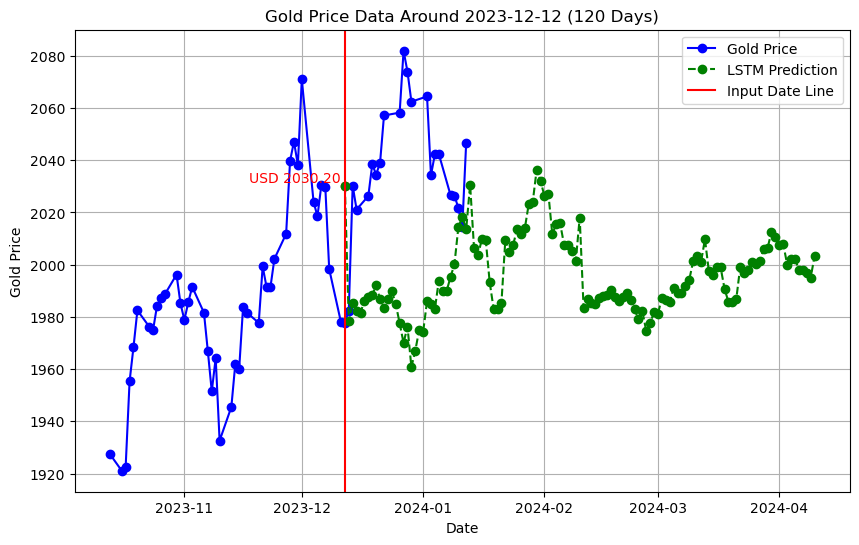

Epoch 1/50
1/1 [==============================] - 1s 667ms/step - loss: 0.2960
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2909
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2858
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2807
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2757
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2708
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2659
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2610
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2562
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2514
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2467
Epoch 12/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2420
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

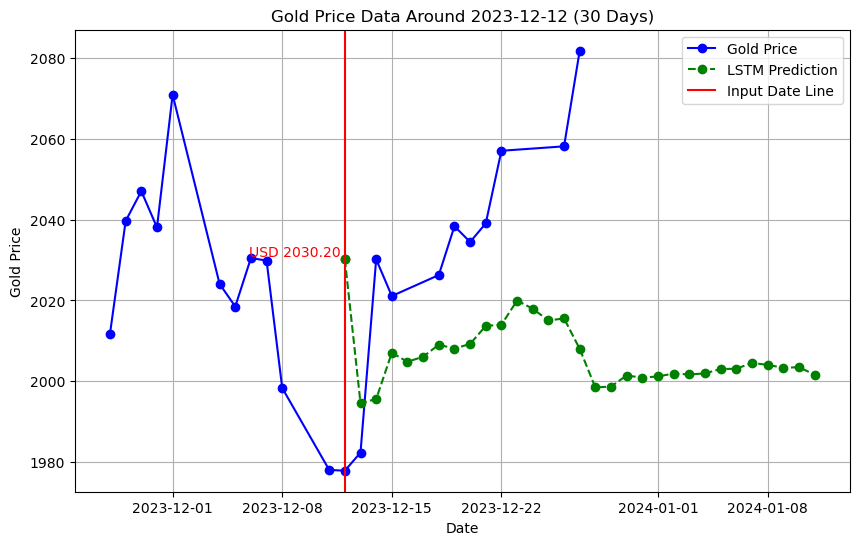

Epoch 1/50
1/1 [==============================] - 1s 665ms/step - loss: 0.3796
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3743
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3691
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3639
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3587
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3536
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3486
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3437
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3388
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3339
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3291
Epoch 12/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3244
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

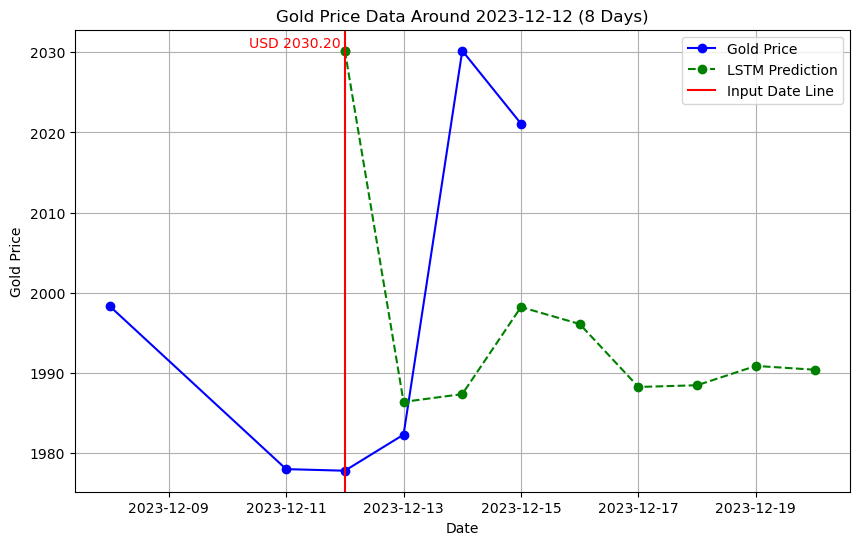

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Download gold price data
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Input date
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# Define different time ranges for visualization
days_ranges = [365, 120, 30, 8]

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to prepare data for LSTM
def prepare_lstm_data(data, input_date, days_before, days_after):
    input_date_index = data[data['Date'] == input_date].index
    if not input_date_index.empty:
        input_date_index = input_date_index[0]
        start_index = max(0, input_date_index - days_before)
        end_index = input_date_index + days_after

        lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        lstm_data_scaled = scaler.fit_transform(lstm_data)

        return lstm_data_scaled, scaler
    else:
        print(f"Input date {input_date} not found in the dataset.")
        return None, None

# Function to train LSTM model
def train_lstm_model(model, X, y, epochs=50, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size)

# Plot multiple charts
for days in days_ranges:
    days_before = days_after = days // 2

    # Filter data
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    # Prepare data for LSTM
    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, days_before, days_after)

    # Check if data is available for input date
    if lstm_data is None:
        continue

    # Split data into training and testing sets
    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # Create LSTM model
    model = create_lstm_model(input_shape=1)

    # Train the model
    train_lstm_model(model, X, y)

    # Predict using LSTM for each day in the range
    predictions = []
    predicted_dates = []
    for day in range(days):
        input_sequence = lstm_data[-days_before:]
        input_sequence = np.reshape(input_sequence, (1, len(input_sequence), 1))
        predicted_price_scaled = model.predict(input_sequence[:, :1, :])
        predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]
        predictions.append(predicted_price)
        predicted_dates.append(input_date + pd.DateOffset(days=day + 1))

        # Update input sequence for the next prediction
        lstm_data = np.append(lstm_data, [[predicted_price_scaled[0, 0]]], axis=0)

    # Group data by date for comparison
    grouped_data = pd.DataFrame({'Date': pd.to_datetime([input_date] + list(predicted_dates)),
                                  'Original Price': [input_date_price] + list(predictions)[:len(predicted_dates)]})

    # Plot chart
    plt.figure(figsize=(10, 6))
    plt.plot(selected_data['Date'], selected_data['Close'], label='Gold Price', marker='o', linestyle='-', color='blue')
    plt.plot(grouped_data['Date'], grouped_data['Original Price'], label='LSTM Prediction', marker='o', linestyle='--', color='green')

    # Mark input date's gold price data point
    plt.scatter(input_date, input_date_price, color='red')

    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')

    # Show input date's gold price value on the chart
    plt.text(input_date, input_date_price, f'USD {input_date_price:.2f} ', ha='right', va='bottom', color='red')

    plt.title(f'Gold Price Data Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-22
Epoch 1/50
7/7 [==============================] - 1s 2ms/step - loss: 0.2946
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2593
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2261
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1946
Epoch 5/50
7/7 [==============================] - 0s 2ms/step - loss: 0.1642
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1362
Epoch 7/50
7/7 [==============================] - 0s 2ms/step - loss: 0.1104
Epoch 8/50
7/7 [==============================] - 0s 2ms/step - loss: 0.0872
Epoch 9/50
7/7 [==============================] - 0s 2ms/step - loss: 0.0671
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0507
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0373
Epoch 12/50
7/7 [===========

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


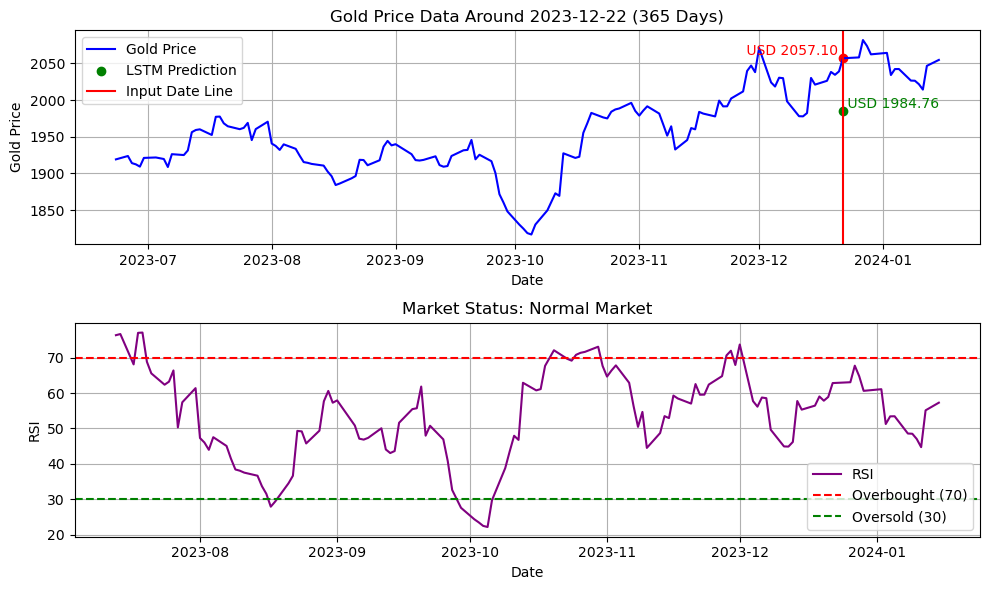

Epoch 1/50
3/3 [==============================] - 1s 2ms/step - loss: 0.4104
Epoch 2/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3900
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3703
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3517
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3332
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3145
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2793
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2619
Epoch 10/50
3/3 [==============================] - 0s 1ms/step - loss: 0.2452
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2290
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2129
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.

1/1 [==============================] - 0s 10ms/step


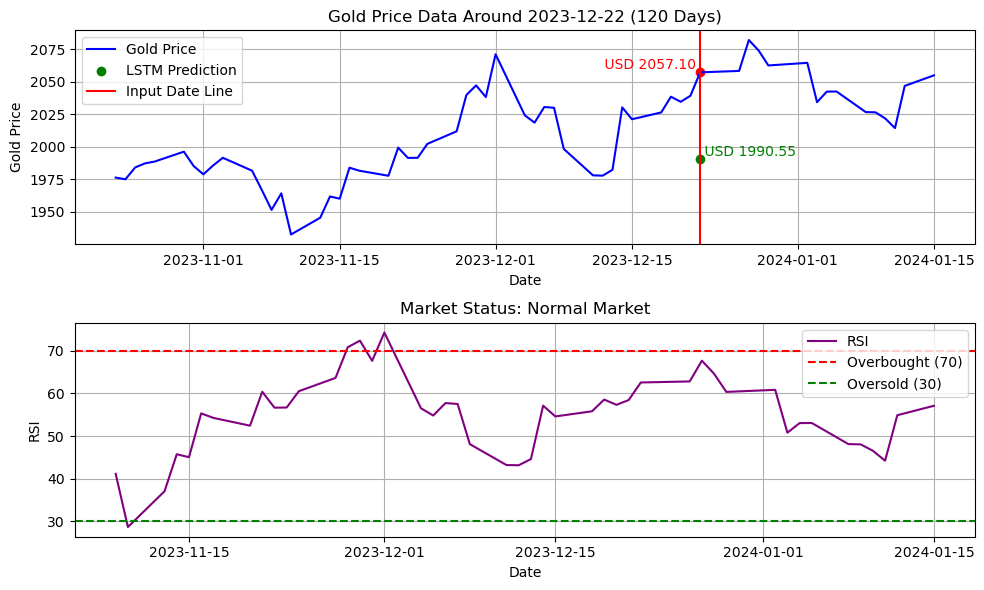

Epoch 1/50
1/1 [==============================] - 1s 682ms/step - loss: 0.3031
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2982
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2933
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2885
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2837
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2790
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2743
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2697
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2651
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2605
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2560
Epoch 12/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2515
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

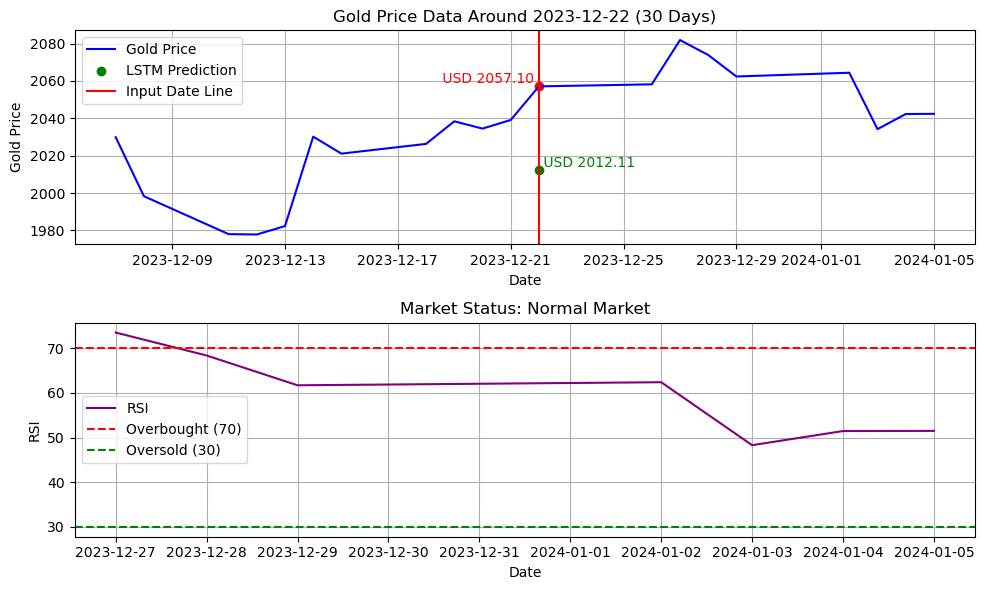

Epoch 1/50
1/1 [==============================] - 1s 648ms/step - loss: 0.3726
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3675
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3625
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3575
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3525
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3476
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3427
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3379
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3331
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3284
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3237
Epoch 12/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3191
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

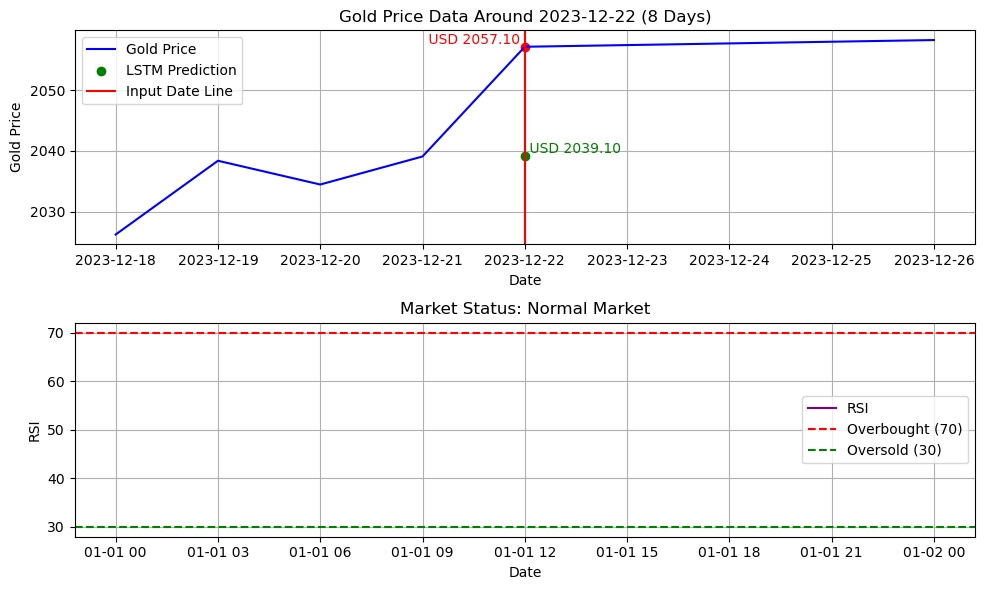

1/1 [==============================] - 0s 9ms/step


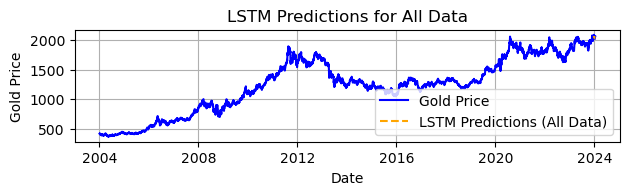

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from ta.momentum import RSIIndicator

# 下载黄金价格数据
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# 输入日期
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# 定义不同时间范围的前后天数
days_ranges = [365, 120, 30, 8]

# 创建LSTM模型的函数
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 准备LSTM数据的函数
def prepare_lstm_data(data, input_date, days_before, days_after):
    input_date_index = data[data['Date'] == input_date].index
    if not input_date_index.empty:
        input_date_index = input_date_index[0]
        start_index = max(0, input_date_index - days_before)
        end_index = input_date_index + days_after

        lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        lstm_data_scaled = scaler.fit_transform(lstm_data)

        return lstm_data_scaled, scaler
    else:
        print(f"Input date {input_date} not found in the dataset.")
        return None, None

# 训练LSTM模型的函数
def train_lstm_model(model, X, y, epochs=50, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size)

# 计算RSI的函数
def calculate_rsi(data):
    indicator = RSIIndicator(data['Close'])
    return indicator.rsi()

# 判断市场状态的函数
def market_status(rsi_value):
    if rsi_value > 70:
        return 'Overbought (Bear Market)'
    elif rsi_value < 30:
        return 'Oversold (Bull Market)'
    else:
        return 'Normal Market'

# 绘制多个图表
for days in days_ranges:
    days_before = days_after = days // 2

    # 筛选数据
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    # 准备数据进行LSTM预测
    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, days_before, days_after)

    # 如果数据不可用，则跳过此次循环
    if lstm_data is None:
        continue

    # 将数据分为训练和测试集
    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)

    # 将输入重塑为 [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # 创建LSTM模型
    model = create_lstm_model(input_shape=1)

    # 训练模型
    train_lstm_model(model, X, y)

    # 如果是在输入日期上进行预测
    if days == 1:
        input_sequence = lstm_data
    else:
        input_sequence = lstm_data[-days_before:]

    # 对于每一天进行LSTM预测
    predictions = []
    for day in range(days):
        input_sequence_reshaped = np.reshape(input_sequence, (1, len(input_sequence), 1))
        predicted_price_scaled = model.predict(input_sequence_reshaped[:, :1, :])
        predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]
        predictions.append(predicted_price)

        # 更新输入序列以进行下一次预测
        input_sequence = np.append(input_sequence, [[predicted_price_scaled[0, 0]]], axis=0)

    # 计算RSI
    rsi_data = calculate_rsi(selected_data)

    # 绘制图表
    plt.figure(figsize=(10, 6))

    # 绘制Gold Price图表
    plt.subplot(2, 1, 1)
    plt.plot(selected_data['Date'], selected_data['Close'], label='Gold Price', linestyle='-', color='blue')
    plt.scatter(input_date, predictions[0], color='green', label='LSTM Prediction')
    plt.text(input_date, predictions[0], f' USD {predictions[0]:.2f} ', ha='left', va='bottom', color='green')
    plt.scatter(input_date, selected_data[selected_data['Date'] == input_date]['Close'].values[0], color='red')
    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')
    close_price = selected_data[selected_data['Date'] == input_date]['Close'].values[0]
    plt.text(input_date, close_price, f' USD {close_price:.2f} ', ha='right', va='bottom', color='red')
    plt.title(f'Gold Price Data Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)

    # 绘制RSI图表
    plt.subplot(2, 1, 2)
    plt.plot(selected_data['Date'], rsi_data, label='RSI', linestyle='-', color='purple')
    plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
    market_status_value = market_status(rsi_data.iloc[-1])
    plt.title(f'Market Status: {market_status_value}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
# 绘制LSTM预测所有数据图表
plt.subplot(3, 1, 3)
all_data = goldDF.copy()
all_lstm_data, _ = prepare_lstm_data(goldDF, input_date, days_before, len(all_data) - 1)

# 如果数据不可用，则跳过此次循环
if all_lstm_data is not None:
    # 将数据分为训练和测试集
    all_X, all_y = [], []
    for i in range(len(all_lstm_data) - 1):
        all_X.append(all_lstm_data[i])
        all_y.append(all_lstm_data[i + 1])

    all_X, all_y = np.array(all_X), np.array(all_y)

    # 将输入重塑为 [samples, time steps, features]
    all_X = np.reshape(all_X, (all_X.shape[0], 1, all_X.shape[1]))

    # 对所有数据进行LSTM预测
    all_predictions = model.predict(all_X)

    # 反归一化预测数据
    all_predictions_prices = scaler.inverse_transform(all_predictions.reshape(-1, 1)).flatten()

    # 绘制图表
    plt.plot(all_data['Date'], all_data['Close'], label='Gold Price', linestyle='-', color='blue')
    plt.plot(all_data['Date'].iloc[-len(all_predictions_prices):], all_predictions_prices,
             label='LSTM Predictions (All Data)', linestyle='--', color='orange')
    plt.title(f'LSTM Predictions for All Data')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# pip install ta    

[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-12
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.3611
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.3190
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2806
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2447
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2114
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1800
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1517
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1246
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1007
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0801
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0618
Epoch 12/50
7/7 [===========

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


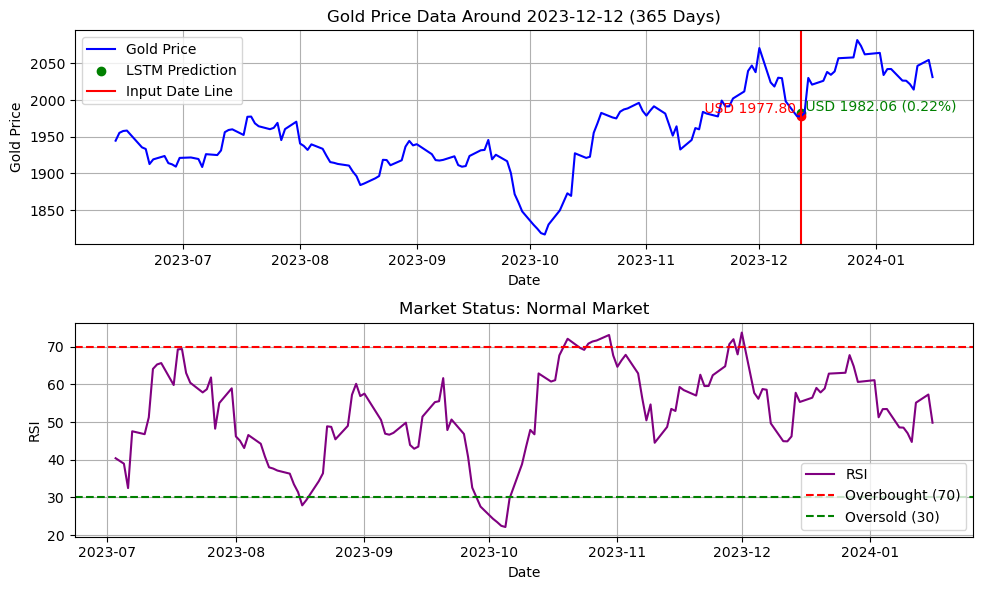

Epoch 1/50
3/3 [==============================] - 1s 2ms/step - loss: 0.4017
Epoch 2/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3823
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3627
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3448
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3260
Epoch 6/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3084
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2917
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2750
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2590
Epoch 10/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2431
Epoch 11/50
3/3 [==============================] - 0s 1ms/step - loss: 0.2281
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2131
Epoch 13/50
3/3 [==============================] - 0s 1ms/step - loss: 0.

1/1 [==============================] - 0s 9ms/step


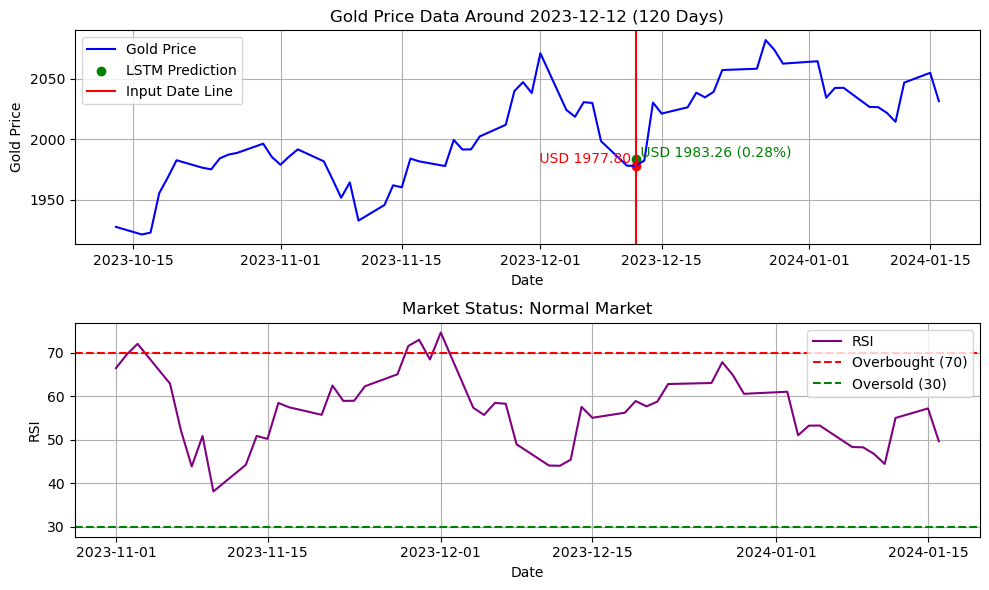

Epoch 1/50
1/1 [==============================] - 1s 652ms/step - loss: 0.3212
Epoch 2/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3154
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3097
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3040
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2984
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2928
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2873
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2818
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2764
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2711
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2658
Epoch 12/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2606
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

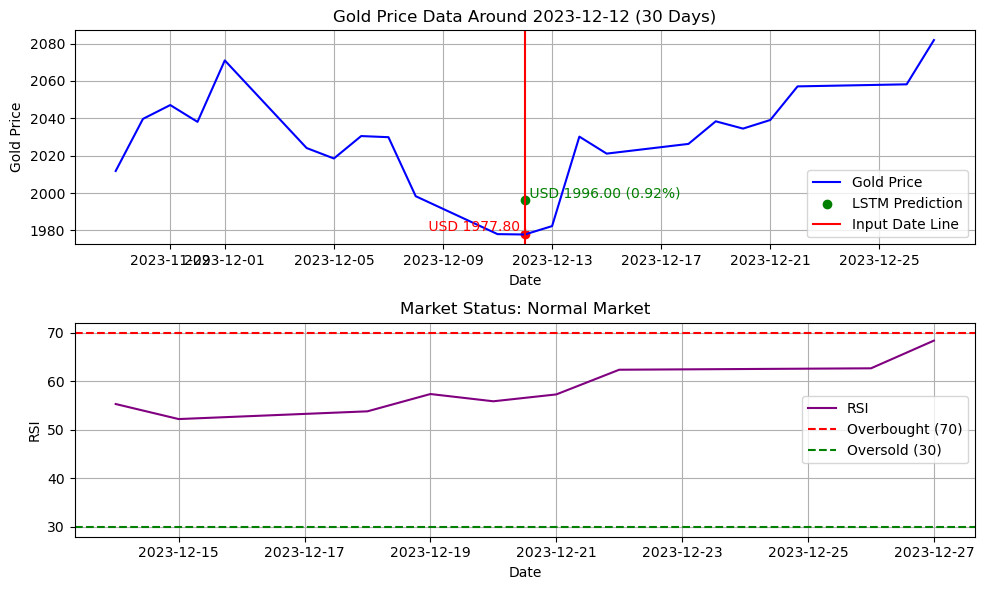

Epoch 1/50
1/1 [==============================] - 1s 689ms/step - loss: 0.4067
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 0.4016
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3967
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3917
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3869
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3821
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3773
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3726
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3679
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3633
Epoch 11/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3588
Epoch 12/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3543
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

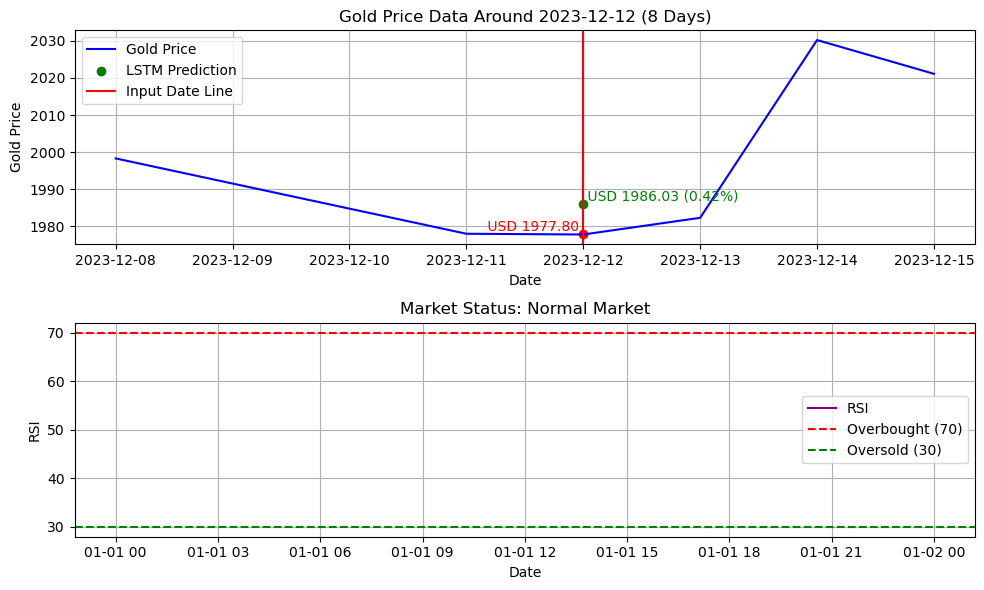

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from ta.momentum import RSIIndicator

# 下载黄金价格数据
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# 输入日期
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# 定义不同时间范围的前后天数
days_ranges = [365, 120, 30, 8]

# 创建LSTM模型的函数
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 准备LSTM数据的函数
def prepare_lstm_data(data, input_date, days_before, days_after):
    input_date_index = data[data['Date'] == input_date].index
    if not input_date_index.empty:
        input_date_index = input_date_index[0]
        start_index = max(0, input_date_index - days_before)
        end_index = input_date_index + days_after

        lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        lstm_data_scaled = scaler.fit_transform(lstm_data)

        return lstm_data_scaled, scaler
    else:
        print(f"Input date {input_date} not found in the dataset.")
        return None, None

# 训练LSTM模型的函数
def train_lstm_model(model, X, y, epochs=50, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size)

# 计算RSI的函数
def calculate_rsi(data):
    indicator = RSIIndicator(data['Close'])
    return indicator.rsi()

# 判断市场状态的函数
def market_status(rsi_value):
    if rsi_value > 70:
        return 'Overbought (Bear Market)'
    elif rsi_value < 30:
        return 'Oversold (Bull Market)'
    else:
        return 'Normal Market'

# 绘制多个图表
for days in days_ranges:
    days_before = days_after = days // 2

    # 筛选数据
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    # 准备数据进行LSTM预测
    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, days_before, days_after)

    # 如果数据不可用，则跳过此次循环
    if lstm_data is None:
        continue

    # 将数据分为训练和测试集
    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)

    # 将输入重塑为 [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # 创建LSTM模型
    model = create_lstm_model(input_shape=1)

    # 训练模型
    train_lstm_model(model, X, y)

    # 如果是在输入日期上进行预测
    if days == 1:
        input_sequence = lstm_data
    else:
        input_sequence = lstm_data[-days_before:]

    # 对于每一天进行LSTM预测
    predictions = []
    for day in range(days):
        input_sequence_reshaped = np.reshape(input_sequence, (1, len(input_sequence), 1))
        predicted_price_scaled = model.predict(input_sequence_reshaped[:, :1, :])
        predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]
        predictions.append(predicted_price)

        # 更新输入序列以进行下一次预测
        input_sequence = np.append(input_sequence, [[predicted_price_scaled[0, 0]]], axis=0)

    # 计算RSI
    rsi_data = calculate_rsi(selected_data)

    # 计算预测价格和原价格的百分比差异
    percentage_difference = ((predictions[0] - selected_data[selected_data['Date'] == input_date]['Close'].values[0]) /
                             selected_data[selected_data['Date'] == input_date]['Close'].values[0]) * 100

    # 绘制图表
    plt.figure(figsize=(10, 6))

    # 绘制Gold Price图表
    plt.subplot(2, 1, 1)
    plt.plot(selected_data['Date'], selected_data['Close'], label='Gold Price', linestyle='-', color='blue')
    plt.scatter(input_date, predictions[0], color='green', label='LSTM Prediction')
    plt.text(input_date, predictions[0], f' USD {predictions[0]:.2f} ({percentage_difference:.2f}%)', ha='left',
             va='bottom', color='green')
    plt.scatter(input_date, selected_data[selected_data['Date'] == input_date]['Close'].values[0], color='red')
    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')
    close_price = selected_data[selected_data['Date'] == input_date]['Close'].values[0]
    plt.text(input_date, close_price, f' USD {close_price:.2f} ', ha='right', va='bottom', color='red')
    plt.title(f'Gold Price Data Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)

    # 绘制RSI图表
    plt.subplot(2, 1, 2)
    plt.plot(selected_data['Date'], rsi_data, label='RSI', linestyle='-', color='purple')
    plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
    market_status_value = market_status(rsi_data.iloc[-1])
    plt.title(f'Market Status: {market_status_value}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-12
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.3729
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.3297
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2894
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2514
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2174
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1833
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1534
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1257
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1010
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0794
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0612
Epoch 12/50
7/7 [===========

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


NameError: name 'predicted_dates' is not defined

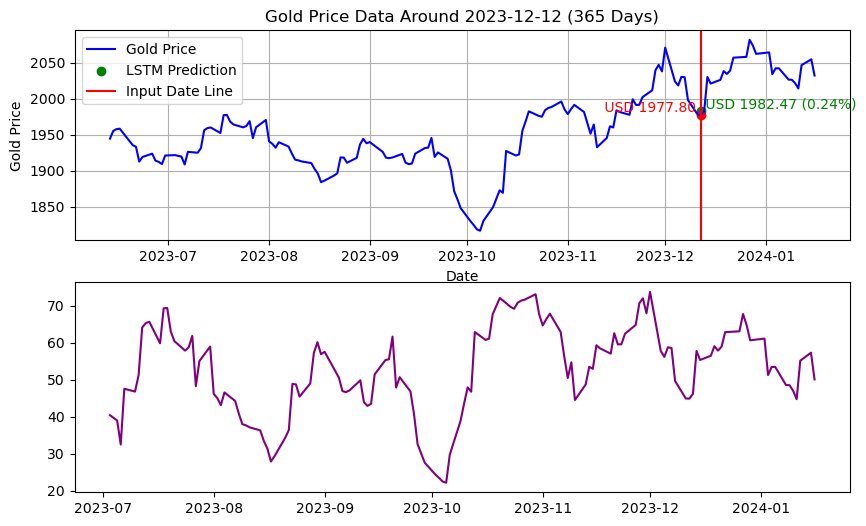

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from ta.momentum import RSIIndicator

ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))
days_ranges = [365, 120, 30, 8]

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def prepare_lstm_data(data, input_date, days_before, days_after):
    input_date_index = data[data['Date'] == input_date].index
    if not input_date_index.empty:
        input_date_index = input_date_index[0]
        start_index = max(0, input_date_index - days_before)
        end_index = input_date_index + days_after
        lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        lstm_data_scaled = scaler.fit_transform(lstm_data)
        return lstm_data_scaled, scaler
    else:
        print(f"Input date {input_date} not found in the dataset.")
        return None, None

def train_lstm_model(model, X, y, epochs=50, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size)

def calculate_rsi(data):
    indicator = RSIIndicator(data['Close'])
    return indicator.rsi()

def market_status(rsi_value):
    if rsi_value > 70:
        return 'Overbought (Bear Market)'
    elif rsi_value < 30:
        return 'Oversold (Bull Market)'
    else:
        return 'Normal Market'

for days in days_ranges:
    days_before = days_after = days // 2
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, days_before, days_after)
    if lstm_data is None:
        continue

    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    model = create_lstm_model(input_shape=1)
    train_lstm_model(model, X, y)

    if days == 1:
        input_sequence = lstm_data
    else:
        input_sequence = lstm_data[-days_before:]

    predictions = []
    for day in range(days):
        input_sequence_reshaped = np.reshape(input_sequence, (1, len(input_sequence), 1))
        predicted_price_scaled = model.predict(input_sequence_reshaped[:, :1, :])
        predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]
        predictions.append(predicted_price)
        input_sequence = np.append(input_sequence, [[predicted_price_scaled[0, 0]]], axis=0)

    rsi_data = calculate_rsi(selected_data)

    percentage_difference = ((predictions[0] - selected_data[selected_data['Date'] == input_date]['Close'].values[0]) /
                             selected_data[selected_data['Date'] == input_date]['Close'].values[0]) * 100

    # Use predictions for RSI calculation and market status
    rsi_predictions = calculate_rsi(pd.DataFrame({'Close': predictions}))
    market_status_value = market_status(rsi_predictions.iloc[-1])

    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(selected_data['Date'], selected_data['Close'], label='Gold Price', linestyle='-', color='blue')
    plt.scatter(input_date, predictions[0], color='green', label='LSTM Prediction')
    plt.text(input_date, predictions[0], f' USD {predictions[0]:.2f} ({percentage_difference:.2f}%)', ha='left',
             va='bottom', color='green')
    plt.scatter(input_date, selected_data[selected_data['Date'] == input_date]['Close'].values[0], color='red')
    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')
    close_price = selected_data[selected_data['Date'] == input_date]['Close'].values[0]
    plt.text(input_date, close_price, f' USD {close_price:.2f} ', ha='right', va='bottom', color='red')
    plt.title(f'Gold Price Data Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(selected_data['Date'], rsi_data, label='RSI (Original)', linestyle='-', color='purple')
    plt.plot(predicted_dates, rsi_predictions, label='RSI (Predicted)', linestyle='--', color='orange')
    plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
    plt.title(f'Market Status: {market_status_value}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


[*********************100%%**********************]  1 of 1 completed

Enter the date to visualize (YYYY-MM-DD): 2023-12-12
Epoch 1/50
7/7 [==============================] - 1s 1ms/step - loss: 0.2961
Epoch 2/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2581
Epoch 3/50
7/7 [==============================] - 0s 1ms/step - loss: 0.2210
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1873
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1557
Epoch 6/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1264
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.1003
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0779
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0589
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0431
Epoch 11/50
7/7 [==============================] - 0s 1ms/step - loss: 0.0321
Epoch 12/50
7/7 [===========

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


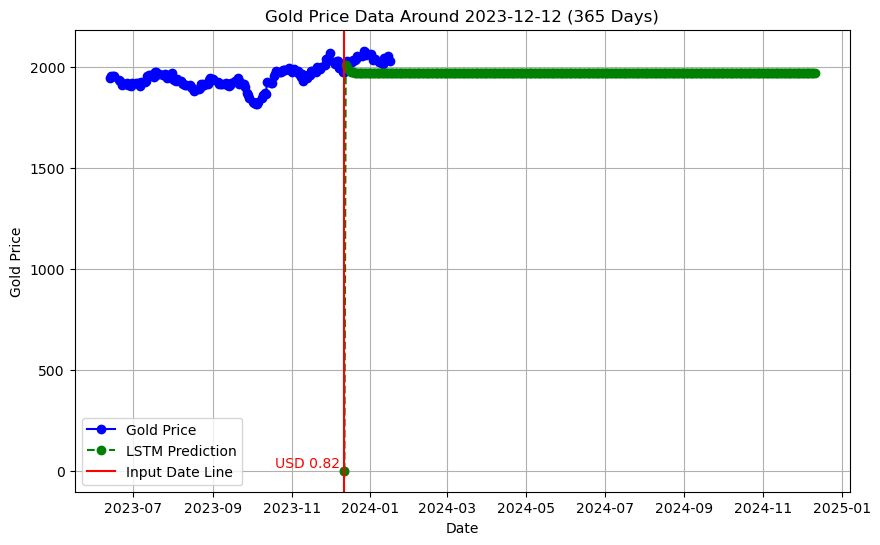

Epoch 1/50
3/3 [==============================] - 1s 2ms/step - loss: 0.3728
Epoch 2/50
3/3 [==============================] - 0s 1ms/step - loss: 0.3534
Epoch 3/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3338
Epoch 4/50
3/3 [==============================] - 0s 2ms/step - loss: 0.3158
Epoch 5/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2965
Epoch 6/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2789
Epoch 7/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2617
Epoch 8/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2446
Epoch 9/50
3/3 [==============================] - 0s 2ms/step - loss: 0.2281
Epoch 10/50
3/3 [==============================] - 0s 1ms/step - loss: 0.2120
Epoch 11/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1970
Epoch 12/50
3/3 [==============================] - 0s 2ms/step - loss: 0.1816
Epoch 13/50
3/3 [==============================] - 0s 2ms/step - loss: 0.

1/1 [==============================] - 0s 11ms/step


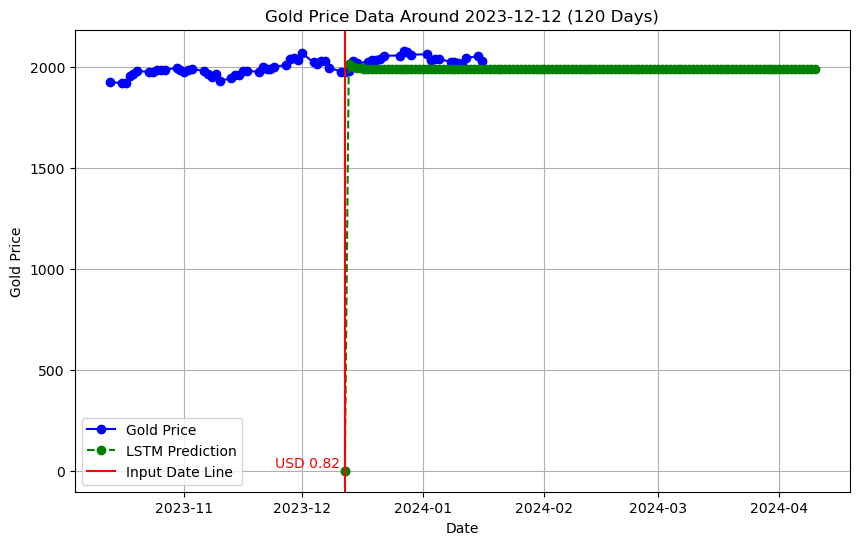

Epoch 1/50
1/1 [==============================] - 1s 711ms/step - loss: 0.3287
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3232
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3178
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3125
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3072
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3020
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2968
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2917
Epoch 9/50
1/1 [==============================] - 0s 2ms/step - loss: 0.2866
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2817
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2767
Epoch 12/50
1/1 [==============================] - 0s 3ms/step - loss: 0.2719
Epoch 13/50
1/1 [==============================] - 0s 3ms/step - loss: 

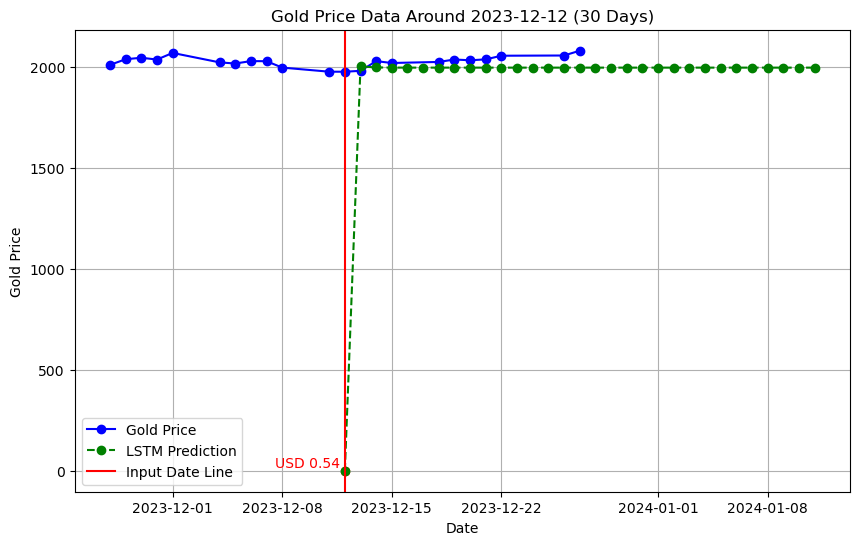

Epoch 1/50
1/1 [==============================] - 1s 702ms/step - loss: 0.3527
Epoch 2/50
1/1 [==============================] - 0s 4ms/step - loss: 0.3480
Epoch 3/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3432
Epoch 4/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3386
Epoch 5/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3340
Epoch 6/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3294
Epoch 7/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3249
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3204
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3159
Epoch 10/50
1/1 [==============================] - 0s 2ms/step - loss: 0.3115
Epoch 11/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3072
Epoch 12/50
1/1 [==============================] - 0s 3ms/step - loss: 0.3028
Epoch 13/50
1/1 [==============================] - 0s 2ms/step - loss: 

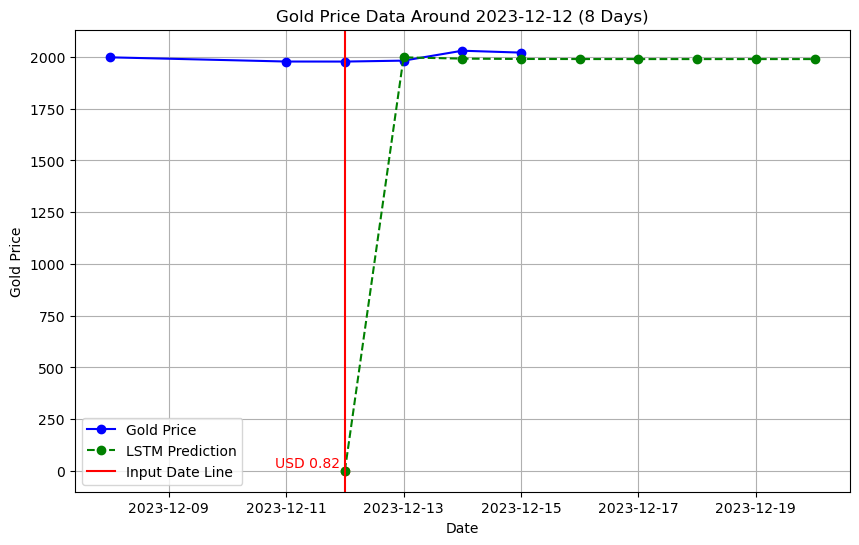

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from ta.momentum import RSIIndicator

# Download gold price data
ticker = 'GC=F'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
gold_data = yf.download(ticker, start='2004-01-01', end=end_date)
goldDF = pd.DataFrame(gold_data).reset_index()

# Input date
input_date = pd.to_datetime(input("\nEnter the date to visualize (YYYY-MM-DD): "))

# Define different time ranges for visualization
days_ranges = [365, 120, 30, 8]

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=(input_shape, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to prepare data for LSTM
def prepare_lstm_data(data, input_date, days_before, days_after):
    input_date_index = data[data['Date'] == input_date].index
    if not input_date_index.empty:
        input_date_index = input_date_index[0]
        start_index = max(0, input_date_index - days_before)
        end_index = input_date_index + days_after

        lstm_data = data['Close'][start_index:end_index].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        lstm_data_scaled = scaler.fit_transform(lstm_data)

        return lstm_data_scaled, scaler
    else:
        print(f"Input date {input_date} not found in the dataset.")
        return None, None

# Function to train LSTM model
def train_lstm_model(model, X, y, epochs=50, batch_size=32):
    model.fit(X, y, epochs=epochs, batch_size=batch_size)

# Function to predict prices
def predict_prices(model, lstm_data, scaler, days):
    predictions = []
    for day in range(days):
        input_sequence = lstm_data[-1:]
        input_sequence = np.reshape(input_sequence, (1, len(input_sequence), 1))
        predicted_price_scaled = model.predict(input_sequence)
        predicted_price = scaler.inverse_transform(predicted_price_scaled.reshape(-1, 1))[0][0]
        predictions.append(predicted_price)
        lstm_data = np.append(lstm_data, [[predicted_price_scaled[0, 0]]], axis=0)
    return predictions

# Plot multiple charts
for days in days_ranges:
    days_before = days_after = days // 2

    # Filter data
    selected_data = goldDF[(goldDF['Date'] >= (input_date - pd.DateOffset(days=days_before))) &
                           (goldDF['Date'] <= (input_date + pd.DateOffset(days=days_after)))]

    # Prepare data for LSTM
    lstm_data, scaler = prepare_lstm_data(goldDF, input_date, days_before, days_after)

    # Check if data is available for input date
    if lstm_data is None:
        continue

    # Split data into training and testing sets
    X, y = [], []
    for i in range(len(lstm_data) - 1):
        X.append(lstm_data[i])
        y.append(lstm_data[i + 1])

    X, y = np.array(X), np.array(y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    # Create LSTM model
    model = create_lstm_model(input_shape=1)

    # Train the model
    train_lstm_model(model, X, y)

    # Predict using LSTM for each day in the range
    predictions = predict_prices(model, lstm_data, scaler, days)

    # Group data by date for comparison
    grouped_data = pd.DataFrame({'Date': pd.to_datetime([input_date] + list(pd.date_range(start=input_date + pd.DateOffset(days=1), periods=days))),
                                  'Original Price': [lstm_data[-1][0]] + predictions})

    # Plot chart
    plt.figure(figsize=(10, 6))
    plt.plot(selected_data['Date'], selected_data['Close'], label='Gold Price', marker='o', linestyle='-', color='blue')
    plt.plot(grouped_data['Date'], grouped_data['Original Price'], label='LSTM Prediction', marker='o', linestyle='--', color='green')

    # Mark input date's gold price data point
    plt.scatter(input_date, lstm_data[-1][0], color='red')

    plt.axvline(x=input_date, color='red', linestyle='-', label='Input Date Line')

    # Show input date's gold price value on the chart
    plt.text(input_date, lstm_data[-1][0], f'USD {lstm_data[-1][0]:.2f} ', ha='right', va='bottom', color='red')

    plt.title(f'Gold Price Data Around {input_date.strftime("%Y-%m-%d")} ({days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.grid(True)
    plt.show()
